In [1]:
import numpy as np                   
import tensorflow as tf               
import matplotlib.pyplot as plt        

from tensorflow.keras import layers, models, optimizers
# layers: Used to build layers of the neural network
# models: To define the architecture of the neural network models (Generator, Discriminator)
# optimizers: To choose the optimization method for training the models

In [2]:
# Generator Model
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=100))  # Input is 100-dim noise
    model.add(layers.Dense(784, activation="sigmoid"))  # Output layer for generating flattened 28x28 image
    model.add(layers.Reshape((28, 28, 1)))
    return model

In [3]:
# Discriminator Model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))  # Flatten 28x28 image into a vector
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))  # Output layer for binary classification (real or fake)
    return model

In [4]:
# Build the models
generator = build_generator()
discriminator = build_discriminator()

d:\Study\New folder\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Study\New folder\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Optimizers for both generator and discriminator
generator_optimizer = optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0001)

In [6]:
# Loss function: Binary crossentropy
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)  #For binary classification tasks (real vs fake)
# from_logits=False ===> because the discriminator's output layer uses a sigmoid activation function,the output is already in the probability range

In [7]:
# Custom training loop for GAN
@tf.function  # For optimization (Tensorflow decorator)
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]  # Get the current batch size

    # Generate fake images
    random_noise = tf.random.normal([batch_size, 100])  # Sample random noise
    generated_images = generator(random_noise)  # Generate images from noise

    real_labels = tf.ones((batch_size, 1))  # Labels for real images (1)
    fake_labels = tf.zeros((batch_size, 1))  # Labels for fake images (0)

    # Train the discriminator on real images
    with tf.GradientTape() as disc_tape:
        real_output = discriminator(real_images)  # Get discriminator's output for real images
        fake_output = discriminator(generated_images)  # Get output for generated images
        disc_real_loss = loss_fn(real_labels, real_output)  # Calculate loss for real images
        disc_fake_loss = loss_fn(fake_labels, fake_output)  # Calculate loss for fake images
        disc_loss = (disc_real_loss + disc_fake_loss) / 2  # Average loss

    # Apply gradients to the discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # Compute gradients
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # Update weights

    # Train the generator (wants the discriminator to classify the fake images as real)
    misleading_labels = tf.ones((batch_size, 1))  # Generator's goal is to produce images classified as real
    with tf.GradientTape() as gen_tape:
        generated_images = generator(random_noise)  # Generate new images
        fake_output = discriminator(generated_images)  # Discriminator's output for generated images
        gen_loss = loss_fn(misleading_labels, fake_output)  # Calculate loss for generator
    
    # Apply gradients to the generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)  # Compute gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))  # Update weights

    return disc_loss, gen_loss

In [8]:
# Training function for the entire GAN model
def train_gan(generator, discriminator, dataset, epochs, batch_size):
    disc_losses = []
    gen_losses = []

    for epoch in range(epochs):
        for real_images in dataset:
            d_loss, g_loss = train_step(real_images)
        
        disc_losses.append(d_loss.numpy())
        gen_losses.append(g_loss.numpy())

        print(f"Epoch {epoch+1}, Discriminator Loss: {d_loss.numpy()}, Generator Loss: {g_loss.numpy()}")
        
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1)

    plot_loss_graphs(disc_losses, gen_losses)

In [9]:
# Function to generate and save images
def generate_and_save_images(generator, epoch, num_examples=16):
    # Generate random noise as input for the generator
    random_noise = tf.random.normal([num_examples, 100])
    generated_images = generator(random_noise)

    # Rescale generated images from [-1, 1] to [0, 255] for visualization
    generated_images = (generated_images * 127.5 + 127.5).numpy()

    plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')  # Display in grayscale
        plt.axis('off')

    plt.show()

In [10]:
# Save the model
def save_model(generator, discriminator):
    generator.save('generator_model.h5')
    discriminator.save('discriminator_model.h5')

In [11]:
# Load the model
def load_model():
    loaded_generator = models.load_model('generator_model.h5')
    loaded_discriminator = models.load_model('discriminator_model.h5')
    return loaded_generator, loaded_discriminator

In [12]:
# Generate images from a saved generator model
def generate_images_from_saved_model():
    loaded_generator, _ = load_model()
    
    # Generate random noise as input for the generator
    random_noise = tf.random.normal([16, 100])
    # Use the generator to create images from the random noise
    generated_images = loaded_generator(random_noise)

    # Rescale images from [-1, 1] to [0, 255] for visualization
    generated_images = (generated_images * 127.5 + 127.5).numpy()

    plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.show()

In [13]:
# Plot loss graphs
def plot_loss_graphs(disc_losses, gen_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.plot(gen_losses, label='Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('GAN Loss Over Time')
    plt.legend()
    plt.show()

In [14]:
# Show real images
def show_real_images(dataset, num_images=16):
    # Retrieve a batch of real images from the dataset
    real_images = next(iter(dataset))  # Get the next batch from the dataset iterator
    real_images = real_images[:num_images]  # Select the specified number of images

    plt.figure(figsize=(4, 4))
    for i in range(real_images.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(real_images[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.show()

In [15]:
# Load the dataset (MNIST)
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()  # Load MNIST dataset, ignore test labels
x_train = x_train / 255.0  # Normalize images to the range [0, 1] for better training
x_train = np.expand_dims(x_train, axis=-1)  # Add a channel dimension (shape: [batch_size, 28, 28, 1])

In [16]:
# Create a batched dataset
batch_size = 64 
# Convert the training data into a TensorFlow dataset, shuffle it, and batch it
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size=1024).batch(batch_size)

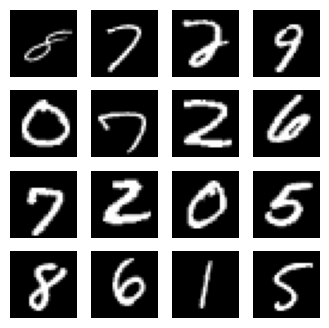

In [17]:
# Show MNIST dataset
show_real_images(dataset)

Epoch 1, Discriminator Loss: 0.09922163188457489, Generator Loss: 2.8083267211914062
Epoch 2, Discriminator Loss: 0.12152315676212311, Generator Loss: 2.0259695053100586
Epoch 3, Discriminator Loss: 0.14548811316490173, Generator Loss: 1.5993541479110718
Epoch 4, Discriminator Loss: 0.0756751298904419, Generator Loss: 2.657388210296631
Epoch 5, Discriminator Loss: 0.1515713483095169, Generator Loss: 2.837904453277588
Epoch 6, Discriminator Loss: 0.21027116477489471, Generator Loss: 2.4894332885742188
Epoch 7, Discriminator Loss: 0.22829368710517883, Generator Loss: 2.494546890258789
Epoch 8, Discriminator Loss: 0.1462315022945404, Generator Loss: 2.403942584991455
Epoch 9, Discriminator Loss: 0.169293612241745, Generator Loss: 2.480482339859009
Epoch 10, Discriminator Loss: 0.11074258387088776, Generator Loss: 3.1288256645202637


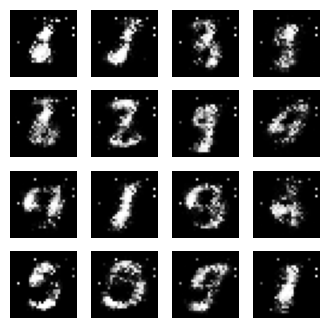

Epoch 11, Discriminator Loss: 0.13374871015548706, Generator Loss: 3.079623222351074
Epoch 12, Discriminator Loss: 0.18259155750274658, Generator Loss: 2.592589855194092
Epoch 13, Discriminator Loss: 0.22979940474033356, Generator Loss: 2.193765640258789
Epoch 14, Discriminator Loss: 0.2908673882484436, Generator Loss: 1.9735535383224487
Epoch 15, Discriminator Loss: 0.11633256822824478, Generator Loss: 2.601099967956543
Epoch 16, Discriminator Loss: 0.12061946094036102, Generator Loss: 2.665843963623047
Epoch 17, Discriminator Loss: 0.22366604208946228, Generator Loss: 2.3502941131591797
Epoch 18, Discriminator Loss: 0.22022920846939087, Generator Loss: 2.4309754371643066
Epoch 19, Discriminator Loss: 0.19329574704170227, Generator Loss: 2.239021062850952
Epoch 20, Discriminator Loss: 0.1624782383441925, Generator Loss: 2.6300745010375977


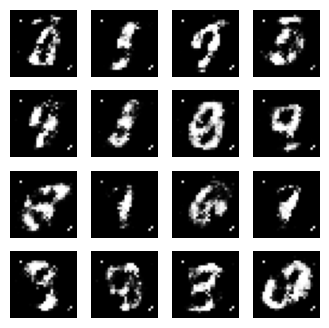

Epoch 21, Discriminator Loss: 0.1684609204530716, Generator Loss: 2.549630641937256
Epoch 22, Discriminator Loss: 0.16889843344688416, Generator Loss: 2.7006332874298096
Epoch 23, Discriminator Loss: 0.16651640832424164, Generator Loss: 2.724997043609619
Epoch 24, Discriminator Loss: 0.14660385251045227, Generator Loss: 2.5528669357299805
Epoch 25, Discriminator Loss: 0.15018650889396667, Generator Loss: 2.704864740371704
Epoch 26, Discriminator Loss: 0.2645050287246704, Generator Loss: 2.613691806793213
Epoch 27, Discriminator Loss: 0.1322774589061737, Generator Loss: 2.913343906402588
Epoch 28, Discriminator Loss: 0.20259538292884827, Generator Loss: 1.92227041721344
Epoch 29, Discriminator Loss: 0.1363745927810669, Generator Loss: 3.4814095497131348
Epoch 30, Discriminator Loss: 0.15200364589691162, Generator Loss: 2.713064670562744


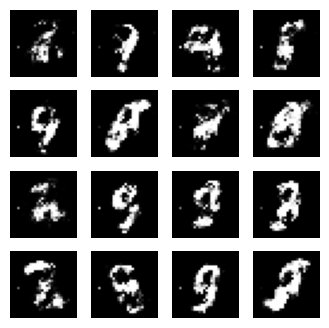

Epoch 31, Discriminator Loss: 0.25381964445114136, Generator Loss: 2.778176784515381
Epoch 32, Discriminator Loss: 0.26748383045196533, Generator Loss: 2.3051743507385254
Epoch 33, Discriminator Loss: 0.2028450071811676, Generator Loss: 2.8669166564941406
Epoch 34, Discriminator Loss: 0.19038064777851105, Generator Loss: 2.4448747634887695
Epoch 35, Discriminator Loss: 0.219636470079422, Generator Loss: 2.2773184776306152
Epoch 36, Discriminator Loss: 0.1793907880783081, Generator Loss: 2.6324334144592285
Epoch 37, Discriminator Loss: 0.29589447379112244, Generator Loss: 2.500080108642578
Epoch 38, Discriminator Loss: 0.1769469827413559, Generator Loss: 2.63893461227417
Epoch 39, Discriminator Loss: 0.16946478188037872, Generator Loss: 3.0191190242767334
Epoch 40, Discriminator Loss: 0.21831652522087097, Generator Loss: 2.388213634490967


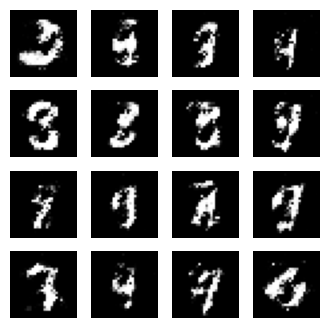

Epoch 41, Discriminator Loss: 0.24053584039211273, Generator Loss: 2.72395658493042
Epoch 42, Discriminator Loss: 0.1696237176656723, Generator Loss: 2.8682706356048584
Epoch 43, Discriminator Loss: 0.23116211593151093, Generator Loss: 2.60591983795166
Epoch 44, Discriminator Loss: 0.19487743079662323, Generator Loss: 3.1207542419433594
Epoch 45, Discriminator Loss: 0.14348047971725464, Generator Loss: 3.123239040374756
Epoch 46, Discriminator Loss: 0.16386288404464722, Generator Loss: 2.4642109870910645
Epoch 47, Discriminator Loss: 0.08771617710590363, Generator Loss: 3.220306873321533
Epoch 48, Discriminator Loss: 0.13638299703598022, Generator Loss: 3.5062482357025146
Epoch 49, Discriminator Loss: 0.19229505956172943, Generator Loss: 2.5891759395599365
Epoch 50, Discriminator Loss: 0.2062309980392456, Generator Loss: 2.606975793838501


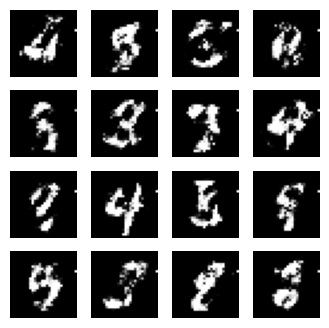

Epoch 51, Discriminator Loss: 0.2969723045825958, Generator Loss: 2.182162046432495
Epoch 52, Discriminator Loss: 0.29423731565475464, Generator Loss: 2.400512218475342
Epoch 53, Discriminator Loss: 0.23329216241836548, Generator Loss: 2.495900869369507
Epoch 54, Discriminator Loss: 0.24116742610931396, Generator Loss: 2.8277759552001953
Epoch 55, Discriminator Loss: 0.31380337476730347, Generator Loss: 2.3259010314941406
Epoch 56, Discriminator Loss: 0.21133077144622803, Generator Loss: 2.5196657180786133
Epoch 57, Discriminator Loss: 0.2473723441362381, Generator Loss: 2.5364980697631836
Epoch 58, Discriminator Loss: 0.20425774157047272, Generator Loss: 3.1007227897644043
Epoch 59, Discriminator Loss: 0.40791597962379456, Generator Loss: 2.173280715942383
Epoch 60, Discriminator Loss: 0.21191810071468353, Generator Loss: 2.769399642944336


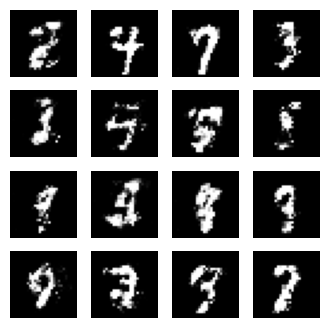

Epoch 61, Discriminator Loss: 0.19363881647586823, Generator Loss: 2.969383955001831
Epoch 62, Discriminator Loss: 0.6166048049926758, Generator Loss: 2.275838613510132
Epoch 63, Discriminator Loss: 0.18844272196292877, Generator Loss: 2.8811821937561035
Epoch 64, Discriminator Loss: 0.8294885158538818, Generator Loss: 1.1240761280059814
Epoch 65, Discriminator Loss: 0.14408352971076965, Generator Loss: 3.6125564575195312
Epoch 66, Discriminator Loss: 0.17148083448410034, Generator Loss: 3.3257858753204346
Epoch 67, Discriminator Loss: 0.2922213077545166, Generator Loss: 2.500649929046631
Epoch 68, Discriminator Loss: 0.2115480601787567, Generator Loss: 2.535785675048828
Epoch 69, Discriminator Loss: 0.15165957808494568, Generator Loss: 2.65793514251709
Epoch 70, Discriminator Loss: 0.614738404750824, Generator Loss: 1.6277827024459839


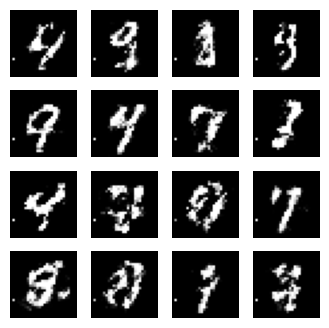

Epoch 71, Discriminator Loss: 0.27195072174072266, Generator Loss: 2.8343043327331543
Epoch 72, Discriminator Loss: 0.6935855150222778, Generator Loss: 1.8553062677383423
Epoch 73, Discriminator Loss: 0.2773374319076538, Generator Loss: 2.962620973587036
Epoch 74, Discriminator Loss: 0.15991048514842987, Generator Loss: 3.257294178009033
Epoch 75, Discriminator Loss: 0.20419834554195404, Generator Loss: 2.641650915145874
Epoch 76, Discriminator Loss: 0.26396751403808594, Generator Loss: 2.3341851234436035
Epoch 77, Discriminator Loss: 0.13751862943172455, Generator Loss: 2.9566922187805176
Epoch 78, Discriminator Loss: 0.16002768278121948, Generator Loss: 2.81131649017334
Epoch 79, Discriminator Loss: 0.18061411380767822, Generator Loss: 2.818608283996582
Epoch 80, Discriminator Loss: 0.23595929145812988, Generator Loss: 2.596312999725342


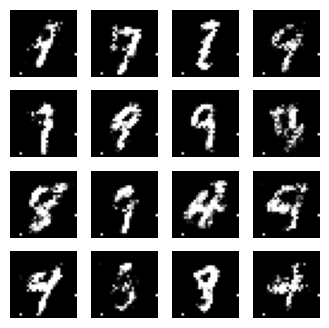

Epoch 81, Discriminator Loss: 0.2991756200790405, Generator Loss: 2.9718217849731445
Epoch 82, Discriminator Loss: 0.829868733882904, Generator Loss: 1.6173276901245117
Epoch 83, Discriminator Loss: 0.14229220151901245, Generator Loss: 3.186643362045288
Epoch 84, Discriminator Loss: 0.32482945919036865, Generator Loss: 2.320828676223755
Epoch 85, Discriminator Loss: 0.7706243991851807, Generator Loss: 1.628209114074707
Epoch 86, Discriminator Loss: 0.21090665459632874, Generator Loss: 3.1221694946289062
Epoch 87, Discriminator Loss: 0.37560802698135376, Generator Loss: 3.1002252101898193
Epoch 88, Discriminator Loss: 0.23603259027004242, Generator Loss: 2.442272663116455
Epoch 89, Discriminator Loss: 1.5511635541915894, Generator Loss: 1.5166881084442139
Epoch 90, Discriminator Loss: 0.25343334674835205, Generator Loss: 2.384464740753174


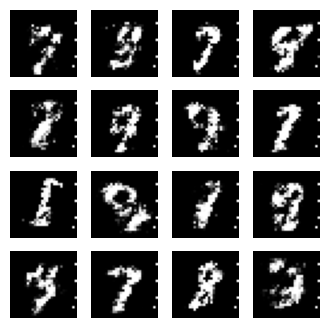

Epoch 91, Discriminator Loss: 0.5021470189094543, Generator Loss: 1.722756266593933
Epoch 92, Discriminator Loss: 0.37245064973831177, Generator Loss: 2.3381876945495605
Epoch 93, Discriminator Loss: 0.21580436825752258, Generator Loss: 2.3944976329803467
Epoch 94, Discriminator Loss: 0.24632962048053741, Generator Loss: 2.4586660861968994
Epoch 95, Discriminator Loss: 0.2801668345928192, Generator Loss: 2.455916166305542
Epoch 96, Discriminator Loss: 0.2972223162651062, Generator Loss: 2.229813575744629
Epoch 97, Discriminator Loss: 0.2151699811220169, Generator Loss: 3.080702543258667
Epoch 98, Discriminator Loss: 0.3639245629310608, Generator Loss: 2.4706122875213623
Epoch 99, Discriminator Loss: 0.1489103138446808, Generator Loss: 2.820997714996338
Epoch 100, Discriminator Loss: 0.2516512870788574, Generator Loss: 2.7216947078704834


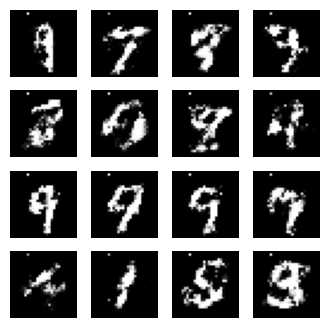

Epoch 101, Discriminator Loss: 0.35439056158065796, Generator Loss: 2.489868402481079
Epoch 102, Discriminator Loss: 0.4060094952583313, Generator Loss: 1.884820580482483
Epoch 103, Discriminator Loss: 0.20212289690971375, Generator Loss: 2.7017393112182617
Epoch 104, Discriminator Loss: 0.41753774881362915, Generator Loss: 2.0326926708221436
Epoch 105, Discriminator Loss: 0.2367602437734604, Generator Loss: 2.370410680770874
Epoch 106, Discriminator Loss: 0.2513660192489624, Generator Loss: 2.4119162559509277
Epoch 107, Discriminator Loss: 0.3355362117290497, Generator Loss: 2.3177833557128906
Epoch 108, Discriminator Loss: 0.3012242317199707, Generator Loss: 2.2420907020568848
Epoch 109, Discriminator Loss: 0.25234973430633545, Generator Loss: 2.0934700965881348
Epoch 110, Discriminator Loss: 0.2663673758506775, Generator Loss: 2.6585729122161865


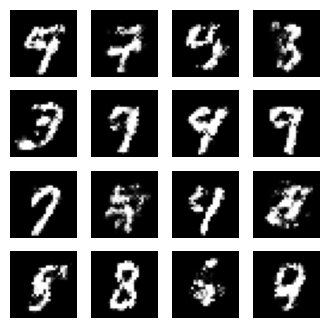

Epoch 111, Discriminator Loss: 0.1410970687866211, Generator Loss: 2.613917350769043
Epoch 112, Discriminator Loss: 0.24493080377578735, Generator Loss: 2.306269645690918
Epoch 113, Discriminator Loss: 0.2269223928451538, Generator Loss: 2.22625732421875
Epoch 114, Discriminator Loss: 0.4385935068130493, Generator Loss: 2.3590335845947266
Epoch 115, Discriminator Loss: 0.2626267075538635, Generator Loss: 2.146336793899536
Epoch 116, Discriminator Loss: 0.21201439201831818, Generator Loss: 2.836446523666382
Epoch 117, Discriminator Loss: 0.3382852077484131, Generator Loss: 1.9479422569274902
Epoch 118, Discriminator Loss: 0.29033398628234863, Generator Loss: 2.59218692779541
Epoch 119, Discriminator Loss: 0.36329880356788635, Generator Loss: 2.1405327320098877
Epoch 120, Discriminator Loss: 0.4143170714378357, Generator Loss: 2.04209041595459


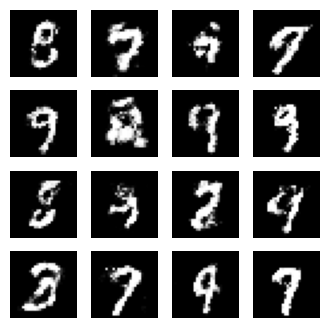

Epoch 121, Discriminator Loss: 0.3986243009567261, Generator Loss: 2.094611406326294
Epoch 122, Discriminator Loss: 0.31467097997665405, Generator Loss: 2.202237606048584
Epoch 123, Discriminator Loss: 0.27601468563079834, Generator Loss: 2.6626088619232178
Epoch 124, Discriminator Loss: 0.2096072882413864, Generator Loss: 2.2313995361328125
Epoch 125, Discriminator Loss: 0.28340083360671997, Generator Loss: 2.143937587738037
Epoch 126, Discriminator Loss: 0.2864411473274231, Generator Loss: 1.8374637365341187
Epoch 127, Discriminator Loss: 0.22194695472717285, Generator Loss: 2.6573870182037354
Epoch 128, Discriminator Loss: 0.2526097893714905, Generator Loss: 2.645089626312256
Epoch 129, Discriminator Loss: 0.33341872692108154, Generator Loss: 2.3282065391540527
Epoch 130, Discriminator Loss: 0.3542013466358185, Generator Loss: 2.099392890930176


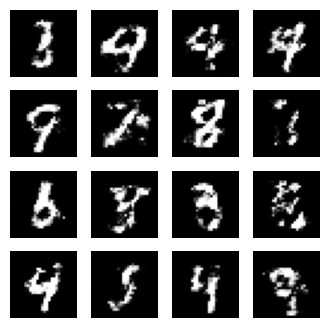

Epoch 131, Discriminator Loss: 0.3147580623626709, Generator Loss: 2.4130420684814453
Epoch 132, Discriminator Loss: 0.5162757635116577, Generator Loss: 2.0213851928710938
Epoch 133, Discriminator Loss: 0.25473302602767944, Generator Loss: 2.018336772918701
Epoch 134, Discriminator Loss: 0.22166486084461212, Generator Loss: 2.222043037414551
Epoch 135, Discriminator Loss: 0.2101553976535797, Generator Loss: 2.3337936401367188
Epoch 136, Discriminator Loss: 0.32312461733818054, Generator Loss: 2.1941676139831543
Epoch 137, Discriminator Loss: 0.33559492230415344, Generator Loss: 2.1802103519439697
Epoch 138, Discriminator Loss: 0.42191097140312195, Generator Loss: 1.7107120752334595
Epoch 139, Discriminator Loss: 0.42399266362190247, Generator Loss: 2.1415066719055176
Epoch 140, Discriminator Loss: 0.2856602966785431, Generator Loss: 2.3688278198242188


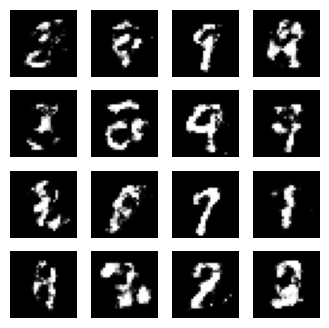

Epoch 141, Discriminator Loss: 0.1921737790107727, Generator Loss: 2.7736759185791016
Epoch 142, Discriminator Loss: 0.21657684445381165, Generator Loss: 2.755916118621826
Epoch 143, Discriminator Loss: 0.2547961473464966, Generator Loss: 2.3442089557647705
Epoch 144, Discriminator Loss: 0.33989831805229187, Generator Loss: 1.8517177104949951
Epoch 145, Discriminator Loss: 0.3210688829421997, Generator Loss: 1.947533130645752
Epoch 146, Discriminator Loss: 0.25739607214927673, Generator Loss: 2.674177646636963
Epoch 147, Discriminator Loss: 0.2633039355278015, Generator Loss: 2.126828908920288
Epoch 148, Discriminator Loss: 0.34557628631591797, Generator Loss: 1.9126763343811035
Epoch 149, Discriminator Loss: 0.4209791421890259, Generator Loss: 1.7827117443084717
Epoch 150, Discriminator Loss: 0.23348258435726166, Generator Loss: 2.132479429244995


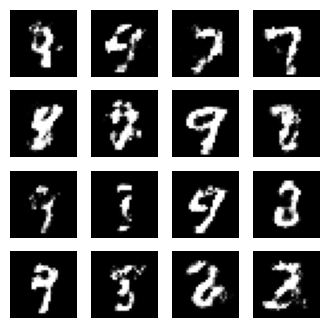

Epoch 151, Discriminator Loss: 0.38928306102752686, Generator Loss: 2.6056466102600098
Epoch 152, Discriminator Loss: 0.3700310289859772, Generator Loss: 2.482273578643799
Epoch 153, Discriminator Loss: 0.3570917844772339, Generator Loss: 2.217817783355713
Epoch 154, Discriminator Loss: 0.3328220248222351, Generator Loss: 2.5022315979003906
Epoch 155, Discriminator Loss: 0.3037172555923462, Generator Loss: 1.9282104969024658
Epoch 156, Discriminator Loss: 0.25119924545288086, Generator Loss: 2.684910535812378
Epoch 157, Discriminator Loss: 0.32874029874801636, Generator Loss: 2.168596029281616
Epoch 158, Discriminator Loss: 0.41489845514297485, Generator Loss: 2.1457934379577637
Epoch 159, Discriminator Loss: 0.4296063184738159, Generator Loss: 1.9300740957260132
Epoch 160, Discriminator Loss: 0.2198384702205658, Generator Loss: 2.161536455154419


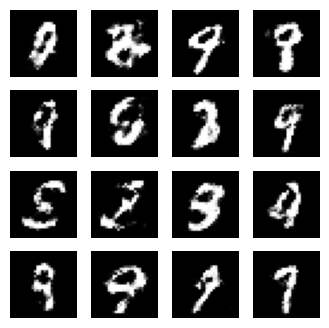

Epoch 161, Discriminator Loss: 0.3137763440608978, Generator Loss: 2.053107261657715
Epoch 162, Discriminator Loss: 0.26756441593170166, Generator Loss: 1.8915469646453857
Epoch 163, Discriminator Loss: 0.3728828728199005, Generator Loss: 2.1575398445129395
Epoch 164, Discriminator Loss: 0.32011914253234863, Generator Loss: 2.357358694076538
Epoch 165, Discriminator Loss: 0.297914981842041, Generator Loss: 1.783984661102295
Epoch 166, Discriminator Loss: 0.28350961208343506, Generator Loss: 2.2634997367858887
Epoch 167, Discriminator Loss: 0.3492738902568817, Generator Loss: 2.071550130844116
Epoch 168, Discriminator Loss: 0.2946106791496277, Generator Loss: 2.3508076667785645
Epoch 169, Discriminator Loss: 0.4305837154388428, Generator Loss: 2.1560471057891846
Epoch 170, Discriminator Loss: 0.4512726366519928, Generator Loss: 2.4490227699279785


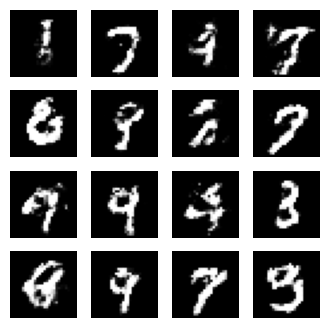

Epoch 171, Discriminator Loss: 0.29610753059387207, Generator Loss: 2.697202205657959
Epoch 172, Discriminator Loss: 0.4364657998085022, Generator Loss: 1.6830897331237793
Epoch 173, Discriminator Loss: 0.2733551263809204, Generator Loss: 1.9727363586425781
Epoch 174, Discriminator Loss: 0.3419504761695862, Generator Loss: 1.750009298324585
Epoch 175, Discriminator Loss: 0.1786021590232849, Generator Loss: 2.6565210819244385
Epoch 176, Discriminator Loss: 0.2850579023361206, Generator Loss: 2.108431339263916
Epoch 177, Discriminator Loss: 0.29277196526527405, Generator Loss: 2.0573456287384033
Epoch 178, Discriminator Loss: 0.21963879466056824, Generator Loss: 2.5535922050476074
Epoch 179, Discriminator Loss: 0.368141770362854, Generator Loss: 2.3753998279571533
Epoch 180, Discriminator Loss: 0.2682783007621765, Generator Loss: 2.1678175926208496


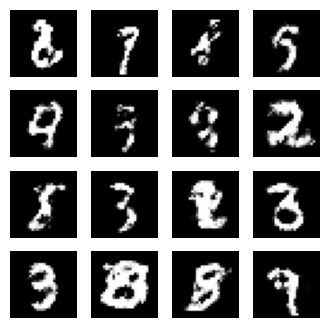

Epoch 181, Discriminator Loss: 0.28365933895111084, Generator Loss: 2.3296542167663574
Epoch 182, Discriminator Loss: 0.3093969225883484, Generator Loss: 2.5680410861968994
Epoch 183, Discriminator Loss: 0.3782702088356018, Generator Loss: 2.5250792503356934
Epoch 184, Discriminator Loss: 0.3090895116329193, Generator Loss: 2.2723536491394043
Epoch 185, Discriminator Loss: 0.269828736782074, Generator Loss: 2.279834747314453
Epoch 186, Discriminator Loss: 0.19677305221557617, Generator Loss: 2.636779546737671
Epoch 187, Discriminator Loss: 0.2948242425918579, Generator Loss: 2.1727845668792725
Epoch 188, Discriminator Loss: 0.21460160613059998, Generator Loss: 2.2147507667541504
Epoch 189, Discriminator Loss: 0.29766684770584106, Generator Loss: 2.341496706008911
Epoch 190, Discriminator Loss: 0.3220369517803192, Generator Loss: 2.243680477142334


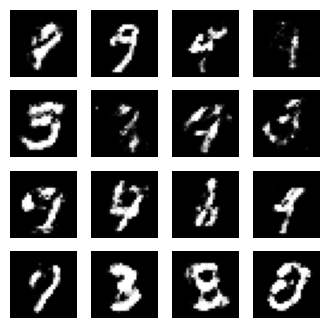

Epoch 191, Discriminator Loss: 0.328039288520813, Generator Loss: 2.5454111099243164
Epoch 192, Discriminator Loss: 0.20427483320236206, Generator Loss: 2.220939874649048
Epoch 193, Discriminator Loss: 0.19264325499534607, Generator Loss: 2.5516679286956787
Epoch 194, Discriminator Loss: 0.3173784911632538, Generator Loss: 2.4149513244628906
Epoch 195, Discriminator Loss: 0.3355615437030792, Generator Loss: 2.1290900707244873
Epoch 196, Discriminator Loss: 0.2638856768608093, Generator Loss: 2.950143814086914
Epoch 197, Discriminator Loss: 0.27685222029685974, Generator Loss: 1.9976962804794312
Epoch 198, Discriminator Loss: 0.39947256445884705, Generator Loss: 2.1518893241882324
Epoch 199, Discriminator Loss: 0.34762898087501526, Generator Loss: 2.188858985900879
Epoch 200, Discriminator Loss: 0.336079865694046, Generator Loss: 2.4315357208251953


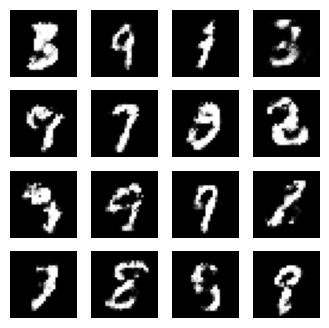

Epoch 201, Discriminator Loss: 0.2639024257659912, Generator Loss: 1.931762456893921
Epoch 202, Discriminator Loss: 0.25223657488822937, Generator Loss: 2.425830364227295
Epoch 203, Discriminator Loss: 0.335363507270813, Generator Loss: 2.0375850200653076
Epoch 204, Discriminator Loss: 0.2627009153366089, Generator Loss: 2.170595407485962
Epoch 205, Discriminator Loss: 0.278376042842865, Generator Loss: 2.418286085128784
Epoch 206, Discriminator Loss: 0.2555016279220581, Generator Loss: 1.9731638431549072
Epoch 207, Discriminator Loss: 0.2582574188709259, Generator Loss: 2.1725378036499023
Epoch 208, Discriminator Loss: 0.2891472578048706, Generator Loss: 2.0443665981292725
Epoch 209, Discriminator Loss: 0.27481698989868164, Generator Loss: 2.2711148262023926
Epoch 210, Discriminator Loss: 0.2533360719680786, Generator Loss: 1.9862972497940063


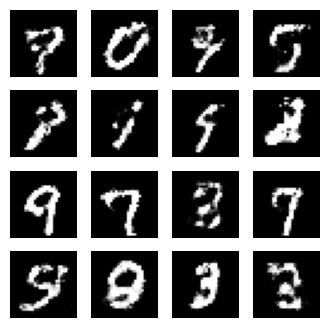

Epoch 211, Discriminator Loss: 0.38532212376594543, Generator Loss: 1.5695533752441406
Epoch 212, Discriminator Loss: 0.2660352289676666, Generator Loss: 2.1428208351135254
Epoch 213, Discriminator Loss: 0.2620648145675659, Generator Loss: 2.5979409217834473
Epoch 214, Discriminator Loss: 0.34686464071273804, Generator Loss: 1.8600459098815918
Epoch 215, Discriminator Loss: 0.25520074367523193, Generator Loss: 2.2035176753997803
Epoch 216, Discriminator Loss: 0.3302176594734192, Generator Loss: 2.142878532409668
Epoch 217, Discriminator Loss: 0.30596309900283813, Generator Loss: 2.29703950881958
Epoch 218, Discriminator Loss: 0.30004173517227173, Generator Loss: 1.7959522008895874
Epoch 219, Discriminator Loss: 0.22182181477546692, Generator Loss: 2.4551587104797363
Epoch 220, Discriminator Loss: 0.3127167224884033, Generator Loss: 2.1577486991882324


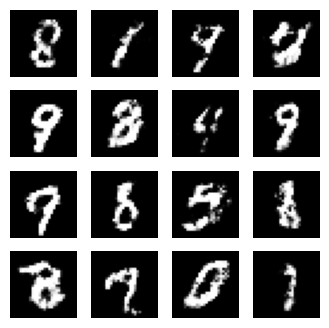

Epoch 221, Discriminator Loss: 0.3269024193286896, Generator Loss: 1.9064102172851562
Epoch 222, Discriminator Loss: 0.33136481046676636, Generator Loss: 2.1728901863098145
Epoch 223, Discriminator Loss: 0.30212926864624023, Generator Loss: 2.16751766204834
Epoch 224, Discriminator Loss: 0.2940949499607086, Generator Loss: 2.021144390106201
Epoch 225, Discriminator Loss: 0.31178176403045654, Generator Loss: 2.06868577003479
Epoch 226, Discriminator Loss: 0.2610887885093689, Generator Loss: 2.1163828372955322
Epoch 227, Discriminator Loss: 0.3209071159362793, Generator Loss: 2.2154030799865723
Epoch 228, Discriminator Loss: 0.41086792945861816, Generator Loss: 2.0862481594085693
Epoch 229, Discriminator Loss: 0.22477732598781586, Generator Loss: 1.935817837715149
Epoch 230, Discriminator Loss: 0.24185656011104584, Generator Loss: 2.537628650665283


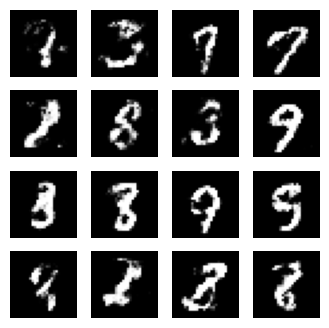

Epoch 231, Discriminator Loss: 0.375215619802475, Generator Loss: 2.096877098083496
Epoch 232, Discriminator Loss: 0.294047087430954, Generator Loss: 2.0130631923675537
Epoch 233, Discriminator Loss: 0.3489311933517456, Generator Loss: 1.8328579664230347
Epoch 234, Discriminator Loss: 0.2849882245063782, Generator Loss: 2.66164493560791
Epoch 235, Discriminator Loss: 0.23474766314029694, Generator Loss: 2.211472511291504
Epoch 236, Discriminator Loss: 0.42303454875946045, Generator Loss: 2.243028402328491
Epoch 237, Discriminator Loss: 0.3125484585762024, Generator Loss: 2.2065463066101074
Epoch 238, Discriminator Loss: 0.29907506704330444, Generator Loss: 2.321450710296631
Epoch 239, Discriminator Loss: 0.28416937589645386, Generator Loss: 2.101818323135376
Epoch 240, Discriminator Loss: 0.31628987193107605, Generator Loss: 2.6069016456604004


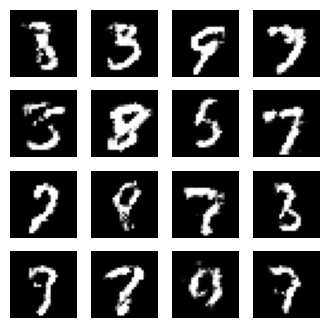

Epoch 241, Discriminator Loss: 0.19626042246818542, Generator Loss: 2.5475339889526367
Epoch 242, Discriminator Loss: 0.2804723083972931, Generator Loss: 2.595597267150879
Epoch 243, Discriminator Loss: 0.2605622410774231, Generator Loss: 2.4486465454101562
Epoch 244, Discriminator Loss: 0.2905331254005432, Generator Loss: 2.0073773860931396
Epoch 245, Discriminator Loss: 0.3169878423213959, Generator Loss: 2.103923797607422
Epoch 246, Discriminator Loss: 0.22464770078659058, Generator Loss: 2.1354732513427734
Epoch 247, Discriminator Loss: 0.28776198625564575, Generator Loss: 2.498202085494995
Epoch 248, Discriminator Loss: 0.30188965797424316, Generator Loss: 2.235628843307495
Epoch 249, Discriminator Loss: 0.3622696101665497, Generator Loss: 1.946373701095581
Epoch 250, Discriminator Loss: 0.21914470195770264, Generator Loss: 2.3679094314575195


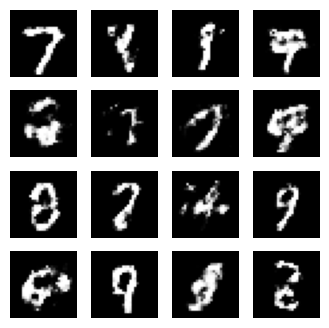

Epoch 251, Discriminator Loss: 0.30028820037841797, Generator Loss: 2.091660261154175
Epoch 252, Discriminator Loss: 0.2867319583892822, Generator Loss: 2.1405415534973145
Epoch 253, Discriminator Loss: 0.2995355725288391, Generator Loss: 2.392279624938965
Epoch 254, Discriminator Loss: 0.32531118392944336, Generator Loss: 2.5435571670532227
Epoch 255, Discriminator Loss: 0.2893105149269104, Generator Loss: 2.3495044708251953
Epoch 256, Discriminator Loss: 0.3473800718784332, Generator Loss: 2.2298731803894043
Epoch 257, Discriminator Loss: 0.218366801738739, Generator Loss: 2.617459297180176
Epoch 258, Discriminator Loss: 0.2895301580429077, Generator Loss: 2.020087718963623
Epoch 259, Discriminator Loss: 0.29393327236175537, Generator Loss: 2.3098196983337402
Epoch 260, Discriminator Loss: 0.2710823118686676, Generator Loss: 2.1991195678710938


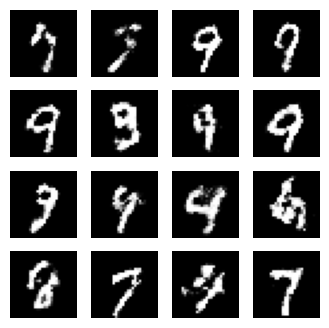

Epoch 261, Discriminator Loss: 0.2424510270357132, Generator Loss: 2.285109519958496
Epoch 262, Discriminator Loss: 0.20141713321208954, Generator Loss: 2.3256313800811768
Epoch 263, Discriminator Loss: 0.28002890944480896, Generator Loss: 2.7255403995513916
Epoch 264, Discriminator Loss: 0.35121721029281616, Generator Loss: 2.111846446990967
Epoch 265, Discriminator Loss: 0.23692309856414795, Generator Loss: 2.6775026321411133
Epoch 266, Discriminator Loss: 0.25257694721221924, Generator Loss: 2.4659767150878906
Epoch 267, Discriminator Loss: 0.3238512873649597, Generator Loss: 2.316687822341919
Epoch 268, Discriminator Loss: 0.26228809356689453, Generator Loss: 2.0268967151641846
Epoch 269, Discriminator Loss: 0.27178698778152466, Generator Loss: 2.256887435913086
Epoch 270, Discriminator Loss: 0.19604942202568054, Generator Loss: 2.538790225982666


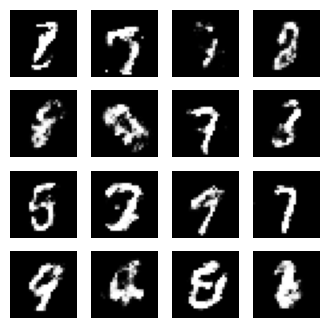

Epoch 271, Discriminator Loss: 0.19434909522533417, Generator Loss: 2.612140417098999
Epoch 272, Discriminator Loss: 0.3281911611557007, Generator Loss: 1.9811173677444458
Epoch 273, Discriminator Loss: 0.2544701397418976, Generator Loss: 2.6501736640930176
Epoch 274, Discriminator Loss: 0.3482040762901306, Generator Loss: 1.9981247186660767
Epoch 275, Discriminator Loss: 0.20093995332717896, Generator Loss: 2.237762928009033
Epoch 276, Discriminator Loss: 0.23360571265220642, Generator Loss: 2.490478992462158
Epoch 277, Discriminator Loss: 0.3726566433906555, Generator Loss: 2.3101072311401367
Epoch 278, Discriminator Loss: 0.166510671377182, Generator Loss: 2.3561222553253174
Epoch 279, Discriminator Loss: 0.35591596364974976, Generator Loss: 1.9460653066635132
Epoch 280, Discriminator Loss: 0.2596866190433502, Generator Loss: 2.358841896057129


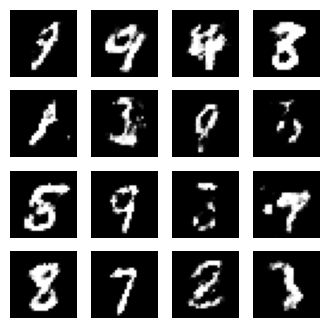

Epoch 281, Discriminator Loss: 0.2941271662712097, Generator Loss: 2.886697769165039
Epoch 282, Discriminator Loss: 0.30333396792411804, Generator Loss: 2.276494026184082
Epoch 283, Discriminator Loss: 0.265524297952652, Generator Loss: 2.586642265319824
Epoch 284, Discriminator Loss: 0.29990237951278687, Generator Loss: 1.8350605964660645
Epoch 285, Discriminator Loss: 0.2220669984817505, Generator Loss: 2.3426599502563477
Epoch 286, Discriminator Loss: 0.2964595854282379, Generator Loss: 2.9484596252441406
Epoch 287, Discriminator Loss: 0.3098461329936981, Generator Loss: 1.9925732612609863
Epoch 288, Discriminator Loss: 0.21800071001052856, Generator Loss: 2.849466323852539
Epoch 289, Discriminator Loss: 0.2817460298538208, Generator Loss: 2.381863594055176
Epoch 290, Discriminator Loss: 0.29072773456573486, Generator Loss: 2.1391422748565674


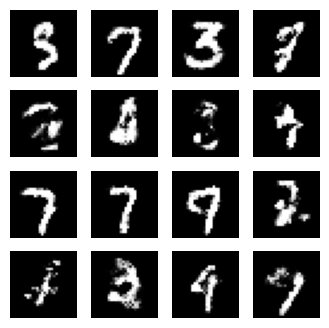

Epoch 291, Discriminator Loss: 0.3122295141220093, Generator Loss: 2.3919804096221924
Epoch 292, Discriminator Loss: 0.22469159960746765, Generator Loss: 2.581679105758667
Epoch 293, Discriminator Loss: 0.287533700466156, Generator Loss: 2.157546281814575
Epoch 294, Discriminator Loss: 0.17881476879119873, Generator Loss: 2.5081543922424316
Epoch 295, Discriminator Loss: 0.4256867468357086, Generator Loss: 2.0436975955963135
Epoch 296, Discriminator Loss: 0.25596708059310913, Generator Loss: 2.5892443656921387
Epoch 297, Discriminator Loss: 0.20923644304275513, Generator Loss: 2.5885891914367676
Epoch 298, Discriminator Loss: 0.31227344274520874, Generator Loss: 2.236504077911377
Epoch 299, Discriminator Loss: 0.31785473227500916, Generator Loss: 2.664032220840454
Epoch 300, Discriminator Loss: 0.24395160377025604, Generator Loss: 2.1332240104675293


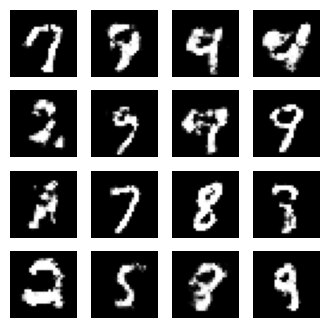

Epoch 301, Discriminator Loss: 0.4082689881324768, Generator Loss: 2.2702555656433105
Epoch 302, Discriminator Loss: 0.23607245087623596, Generator Loss: 2.347836494445801
Epoch 303, Discriminator Loss: 0.2876015901565552, Generator Loss: 2.7697861194610596
Epoch 304, Discriminator Loss: 0.32710814476013184, Generator Loss: 2.4086713790893555
Epoch 305, Discriminator Loss: 0.2658705711364746, Generator Loss: 2.4265542030334473
Epoch 306, Discriminator Loss: 0.3816640377044678, Generator Loss: 2.5290467739105225
Epoch 307, Discriminator Loss: 0.3444436192512512, Generator Loss: 2.10770845413208
Epoch 308, Discriminator Loss: 0.23740515112876892, Generator Loss: 2.208566665649414
Epoch 309, Discriminator Loss: 0.25018709897994995, Generator Loss: 2.5616393089294434
Epoch 310, Discriminator Loss: 0.3366745710372925, Generator Loss: 2.4461801052093506


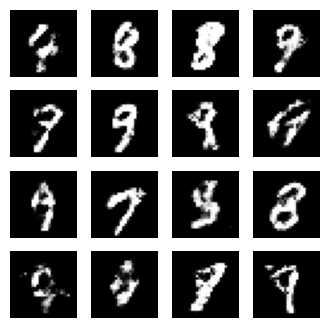

Epoch 311, Discriminator Loss: 0.20306864380836487, Generator Loss: 2.7026443481445312
Epoch 312, Discriminator Loss: 0.31805795431137085, Generator Loss: 2.56655216217041
Epoch 313, Discriminator Loss: 0.24557766318321228, Generator Loss: 2.1272263526916504
Epoch 314, Discriminator Loss: 0.2131742238998413, Generator Loss: 2.8687076568603516
Epoch 315, Discriminator Loss: 0.24164153635501862, Generator Loss: 2.5905141830444336
Epoch 316, Discriminator Loss: 0.3067924678325653, Generator Loss: 2.1608681678771973
Epoch 317, Discriminator Loss: 0.3792092204093933, Generator Loss: 2.01965594291687
Epoch 318, Discriminator Loss: 0.21864071488380432, Generator Loss: 2.757573366165161
Epoch 319, Discriminator Loss: 0.26699894666671753, Generator Loss: 2.585692882537842
Epoch 320, Discriminator Loss: 0.3027293384075165, Generator Loss: 2.6684789657592773


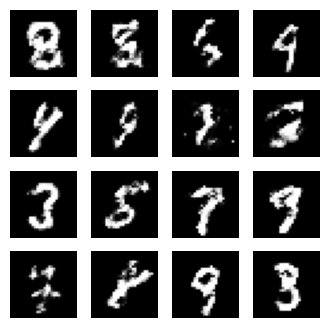

Epoch 321, Discriminator Loss: 0.25427114963531494, Generator Loss: 2.539407730102539
Epoch 322, Discriminator Loss: 0.2809564471244812, Generator Loss: 2.623107433319092
Epoch 323, Discriminator Loss: 0.24323570728302002, Generator Loss: 2.6518054008483887
Epoch 324, Discriminator Loss: 0.28424566984176636, Generator Loss: 2.3932673931121826
Epoch 325, Discriminator Loss: 0.31953901052474976, Generator Loss: 2.1885738372802734
Epoch 326, Discriminator Loss: 0.2962360978126526, Generator Loss: 2.355203628540039
Epoch 327, Discriminator Loss: 0.3012655973434448, Generator Loss: 2.1014089584350586
Epoch 328, Discriminator Loss: 0.3796192407608032, Generator Loss: 2.3494367599487305
Epoch 329, Discriminator Loss: 0.25986361503601074, Generator Loss: 2.262639045715332
Epoch 330, Discriminator Loss: 0.30629032850265503, Generator Loss: 2.101494789123535


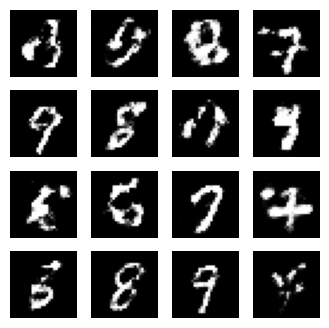

Epoch 331, Discriminator Loss: 0.30902689695358276, Generator Loss: 2.7971878051757812
Epoch 332, Discriminator Loss: 0.2562263309955597, Generator Loss: 2.2956840991973877
Epoch 333, Discriminator Loss: 0.2729480564594269, Generator Loss: 2.5049679279327393
Epoch 334, Discriminator Loss: 0.27513688802719116, Generator Loss: 2.300609588623047
Epoch 335, Discriminator Loss: 0.2503780722618103, Generator Loss: 2.673393726348877
Epoch 336, Discriminator Loss: 0.35030391812324524, Generator Loss: 2.1966471672058105
Epoch 337, Discriminator Loss: 0.24083223938941956, Generator Loss: 2.091930389404297
Epoch 338, Discriminator Loss: 0.31236690282821655, Generator Loss: 2.6809444427490234
Epoch 339, Discriminator Loss: 0.20471961796283722, Generator Loss: 2.616330146789551
Epoch 340, Discriminator Loss: 0.18190693855285645, Generator Loss: 2.6048314571380615


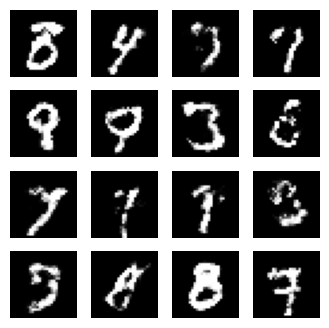

Epoch 341, Discriminator Loss: 0.3006637692451477, Generator Loss: 2.373823642730713
Epoch 342, Discriminator Loss: 0.23658651113510132, Generator Loss: 2.1935667991638184
Epoch 343, Discriminator Loss: 0.34162119030952454, Generator Loss: 2.2618587017059326
Epoch 344, Discriminator Loss: 0.2977864444255829, Generator Loss: 2.6352124214172363
Epoch 345, Discriminator Loss: 0.19037050008773804, Generator Loss: 2.1854403018951416
Epoch 346, Discriminator Loss: 0.2548329830169678, Generator Loss: 2.8605728149414062
Epoch 347, Discriminator Loss: 0.19301147758960724, Generator Loss: 2.880009889602661
Epoch 348, Discriminator Loss: 0.32036060094833374, Generator Loss: 2.38140869140625
Epoch 349, Discriminator Loss: 0.3658097982406616, Generator Loss: 2.520695209503174
Epoch 350, Discriminator Loss: 0.391873836517334, Generator Loss: 1.694471836090088


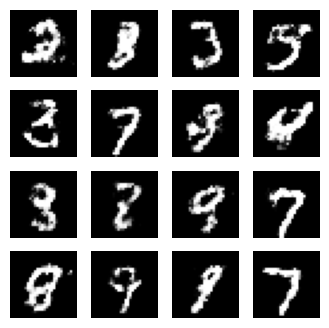

Epoch 351, Discriminator Loss: 0.18652886152267456, Generator Loss: 2.6808722019195557
Epoch 352, Discriminator Loss: 0.3150622248649597, Generator Loss: 2.5840096473693848
Epoch 353, Discriminator Loss: 0.2523880898952484, Generator Loss: 2.689972400665283
Epoch 354, Discriminator Loss: 0.2676427960395813, Generator Loss: 2.4979004859924316
Epoch 355, Discriminator Loss: 0.34732586145401, Generator Loss: 2.4970908164978027
Epoch 356, Discriminator Loss: 0.3171371519565582, Generator Loss: 2.6450765132904053
Epoch 357, Discriminator Loss: 0.27095842361450195, Generator Loss: 2.763211727142334
Epoch 358, Discriminator Loss: 0.3640952706336975, Generator Loss: 2.397007465362549
Epoch 359, Discriminator Loss: 0.2067226767539978, Generator Loss: 2.6758456230163574
Epoch 360, Discriminator Loss: 0.29589173197746277, Generator Loss: 2.1286864280700684


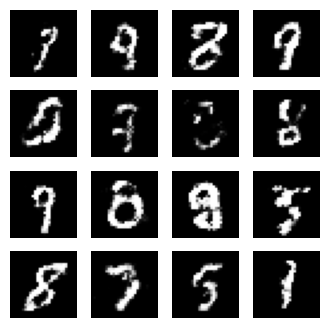

Epoch 361, Discriminator Loss: 0.3715553879737854, Generator Loss: 2.5121116638183594
Epoch 362, Discriminator Loss: 0.2668493390083313, Generator Loss: 2.616718292236328
Epoch 363, Discriminator Loss: 0.3082878589630127, Generator Loss: 2.6608848571777344
Epoch 364, Discriminator Loss: 0.3519905209541321, Generator Loss: 2.6100926399230957
Epoch 365, Discriminator Loss: 0.29610228538513184, Generator Loss: 2.6887826919555664
Epoch 366, Discriminator Loss: 0.30636537075042725, Generator Loss: 2.1161093711853027
Epoch 367, Discriminator Loss: 0.41646111011505127, Generator Loss: 2.3237249851226807
Epoch 368, Discriminator Loss: 0.3672007620334625, Generator Loss: 2.7255682945251465
Epoch 369, Discriminator Loss: 0.3978908658027649, Generator Loss: 2.3766555786132812
Epoch 370, Discriminator Loss: 0.36148881912231445, Generator Loss: 2.336099147796631


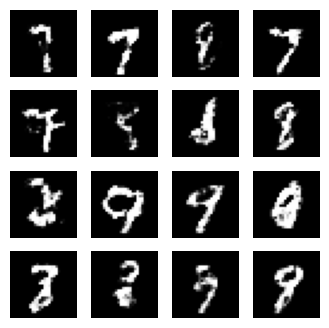

Epoch 371, Discriminator Loss: 0.34525561332702637, Generator Loss: 2.1966543197631836
Epoch 372, Discriminator Loss: 0.2003607153892517, Generator Loss: 3.0666561126708984
Epoch 373, Discriminator Loss: 0.34915482997894287, Generator Loss: 2.6591877937316895
Epoch 374, Discriminator Loss: 0.2720263600349426, Generator Loss: 2.2376489639282227
Epoch 375, Discriminator Loss: 0.2729130685329437, Generator Loss: 2.3228604793548584
Epoch 376, Discriminator Loss: 0.33957746624946594, Generator Loss: 2.362558364868164
Epoch 377, Discriminator Loss: 0.37148672342300415, Generator Loss: 2.234598159790039
Epoch 378, Discriminator Loss: 0.3291836977005005, Generator Loss: 2.077624559402466
Epoch 379, Discriminator Loss: 0.29903873801231384, Generator Loss: 2.9222843647003174
Epoch 380, Discriminator Loss: 0.29206061363220215, Generator Loss: 2.405255079269409


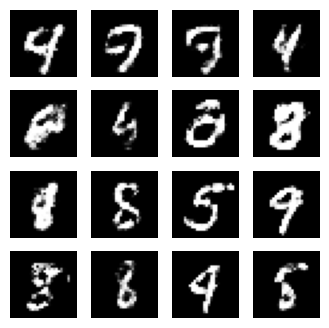

Epoch 381, Discriminator Loss: 0.2538428008556366, Generator Loss: 2.1868720054626465
Epoch 382, Discriminator Loss: 0.22685594856739044, Generator Loss: 3.2357263565063477
Epoch 383, Discriminator Loss: 0.267652690410614, Generator Loss: 2.7194957733154297
Epoch 384, Discriminator Loss: 0.3275861442089081, Generator Loss: 2.461254358291626
Epoch 385, Discriminator Loss: 0.35361385345458984, Generator Loss: 2.318674325942993
Epoch 386, Discriminator Loss: 0.2237142026424408, Generator Loss: 2.876565456390381
Epoch 387, Discriminator Loss: 0.22662357985973358, Generator Loss: 2.5195064544677734
Epoch 388, Discriminator Loss: 0.3459727168083191, Generator Loss: 2.5449395179748535
Epoch 389, Discriminator Loss: 0.23281757533550262, Generator Loss: 2.5419135093688965
Epoch 390, Discriminator Loss: 0.24794195592403412, Generator Loss: 2.321052312850952


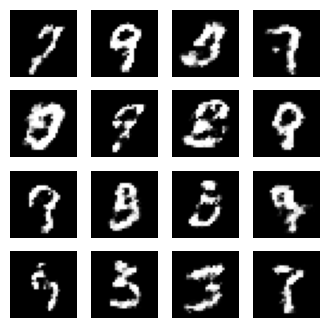

Epoch 391, Discriminator Loss: 0.3404707908630371, Generator Loss: 2.6216111183166504
Epoch 392, Discriminator Loss: 0.3213164210319519, Generator Loss: 2.3297080993652344
Epoch 393, Discriminator Loss: 0.2940050959587097, Generator Loss: 2.099323272705078
Epoch 394, Discriminator Loss: 0.209617018699646, Generator Loss: 3.210300922393799
Epoch 395, Discriminator Loss: 0.36750662326812744, Generator Loss: 2.4688761234283447
Epoch 396, Discriminator Loss: 0.35073357820510864, Generator Loss: 2.3194098472595215
Epoch 397, Discriminator Loss: 0.3140965700149536, Generator Loss: 2.7059502601623535
Epoch 398, Discriminator Loss: 0.2812011241912842, Generator Loss: 3.007941246032715
Epoch 399, Discriminator Loss: 0.16611292958259583, Generator Loss: 2.630652904510498
Epoch 400, Discriminator Loss: 0.21592143177986145, Generator Loss: 3.2832677364349365


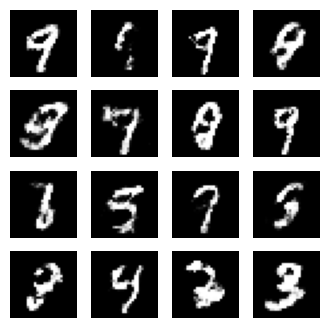

Epoch 401, Discriminator Loss: 0.22217591106891632, Generator Loss: 2.9081990718841553
Epoch 402, Discriminator Loss: 0.25852707028388977, Generator Loss: 3.0511465072631836
Epoch 403, Discriminator Loss: 0.3301633298397064, Generator Loss: 2.241865396499634
Epoch 404, Discriminator Loss: 0.33304324746131897, Generator Loss: 2.341782569885254
Epoch 405, Discriminator Loss: 0.25248387455940247, Generator Loss: 2.086556911468506
Epoch 406, Discriminator Loss: 0.32615864276885986, Generator Loss: 2.14517879486084
Epoch 407, Discriminator Loss: 0.32788699865341187, Generator Loss: 2.6886801719665527
Epoch 408, Discriminator Loss: 0.3708224296569824, Generator Loss: 2.4884352684020996
Epoch 409, Discriminator Loss: 0.2697824239730835, Generator Loss: 2.2623965740203857
Epoch 410, Discriminator Loss: 0.3013877272605896, Generator Loss: 2.392996311187744


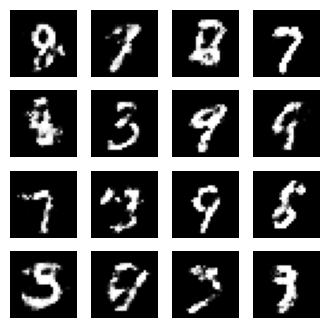

Epoch 411, Discriminator Loss: 0.2821049392223358, Generator Loss: 1.9316508769989014
Epoch 412, Discriminator Loss: 0.24355509877204895, Generator Loss: 2.3806276321411133
Epoch 413, Discriminator Loss: 0.28265947103500366, Generator Loss: 3.0684170722961426
Epoch 414, Discriminator Loss: 0.3683648705482483, Generator Loss: 2.594895362854004
Epoch 415, Discriminator Loss: 0.29346466064453125, Generator Loss: 2.7242681980133057
Epoch 416, Discriminator Loss: 0.3184056878089905, Generator Loss: 2.6959662437438965
Epoch 417, Discriminator Loss: 0.3301016688346863, Generator Loss: 2.6899988651275635
Epoch 418, Discriminator Loss: 0.340402215719223, Generator Loss: 2.695044994354248
Epoch 419, Discriminator Loss: 0.2513050436973572, Generator Loss: 2.7363510131835938
Epoch 420, Discriminator Loss: 0.20907342433929443, Generator Loss: 2.8608665466308594


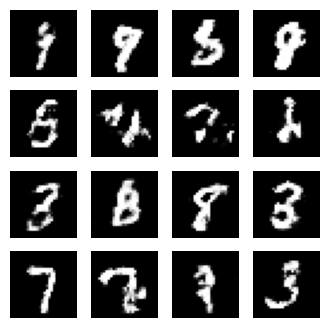

Epoch 421, Discriminator Loss: 0.4266115427017212, Generator Loss: 2.6849896907806396
Epoch 422, Discriminator Loss: 0.3182290494441986, Generator Loss: 2.8380942344665527
Epoch 423, Discriminator Loss: 0.2248813807964325, Generator Loss: 2.9724817276000977
Epoch 424, Discriminator Loss: 0.3083221912384033, Generator Loss: 2.201282501220703
Epoch 425, Discriminator Loss: 0.22573408484458923, Generator Loss: 2.4447624683380127
Epoch 426, Discriminator Loss: 0.2092757374048233, Generator Loss: 2.8526740074157715
Epoch 427, Discriminator Loss: 0.3051658272743225, Generator Loss: 2.852820873260498
Epoch 428, Discriminator Loss: 0.2739652991294861, Generator Loss: 2.5498175621032715
Epoch 429, Discriminator Loss: 0.28727829456329346, Generator Loss: 2.7106146812438965
Epoch 430, Discriminator Loss: 0.3034433126449585, Generator Loss: 2.5130722522735596


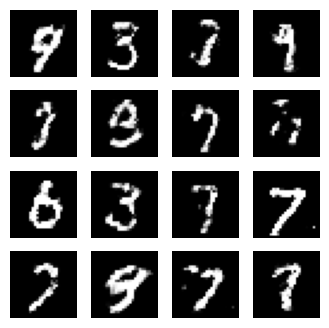

Epoch 431, Discriminator Loss: 0.43303364515304565, Generator Loss: 2.3265504837036133
Epoch 432, Discriminator Loss: 0.31278878450393677, Generator Loss: 2.484654426574707
Epoch 433, Discriminator Loss: 0.3000389039516449, Generator Loss: 2.491236925125122
Epoch 434, Discriminator Loss: 0.38746920228004456, Generator Loss: 2.4809744358062744
Epoch 435, Discriminator Loss: 0.2074158489704132, Generator Loss: 2.5634918212890625
Epoch 436, Discriminator Loss: 0.1904427707195282, Generator Loss: 3.128051280975342
Epoch 437, Discriminator Loss: 0.2138645350933075, Generator Loss: 2.6231508255004883
Epoch 438, Discriminator Loss: 0.3500935435295105, Generator Loss: 3.0041072368621826
Epoch 439, Discriminator Loss: 0.3287583291530609, Generator Loss: 2.9067883491516113
Epoch 440, Discriminator Loss: 0.2093227207660675, Generator Loss: 2.712604522705078


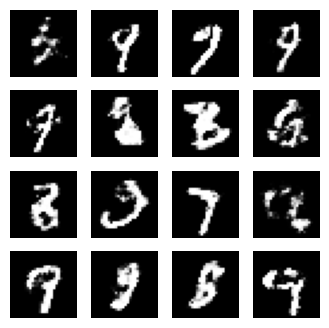

Epoch 441, Discriminator Loss: 0.22306419909000397, Generator Loss: 2.0562267303466797
Epoch 442, Discriminator Loss: 0.37985819578170776, Generator Loss: 2.419790744781494
Epoch 443, Discriminator Loss: 0.2446000874042511, Generator Loss: 3.1856791973114014
Epoch 444, Discriminator Loss: 0.3613276481628418, Generator Loss: 2.4800209999084473
Epoch 445, Discriminator Loss: 0.17909076809883118, Generator Loss: 3.1864137649536133
Epoch 446, Discriminator Loss: 0.29367661476135254, Generator Loss: 2.3594870567321777
Epoch 447, Discriminator Loss: 0.3019319474697113, Generator Loss: 2.7399098873138428
Epoch 448, Discriminator Loss: 0.28755223751068115, Generator Loss: 2.606104850769043
Epoch 449, Discriminator Loss: 0.24188560247421265, Generator Loss: 2.6538023948669434
Epoch 450, Discriminator Loss: 0.29342854022979736, Generator Loss: 2.619811534881592


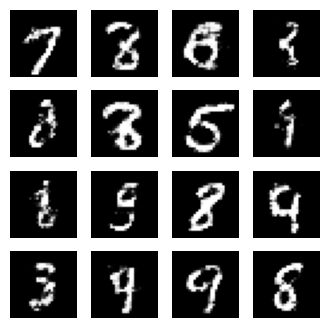

Epoch 451, Discriminator Loss: 0.3332613706588745, Generator Loss: 2.1480650901794434
Epoch 452, Discriminator Loss: 0.1745086908340454, Generator Loss: 2.670499086380005
Epoch 453, Discriminator Loss: 0.21889643371105194, Generator Loss: 2.461294174194336
Epoch 454, Discriminator Loss: 0.1455506682395935, Generator Loss: 2.723238945007324
Epoch 455, Discriminator Loss: 0.36165279150009155, Generator Loss: 2.253958225250244
Epoch 456, Discriminator Loss: 0.30532243847846985, Generator Loss: 2.0496950149536133
Epoch 457, Discriminator Loss: 0.2505178153514862, Generator Loss: 3.191972255706787
Epoch 458, Discriminator Loss: 0.1928381621837616, Generator Loss: 2.2872118949890137
Epoch 459, Discriminator Loss: 0.2578505277633667, Generator Loss: 2.369391441345215
Epoch 460, Discriminator Loss: 0.24062156677246094, Generator Loss: 2.408916473388672


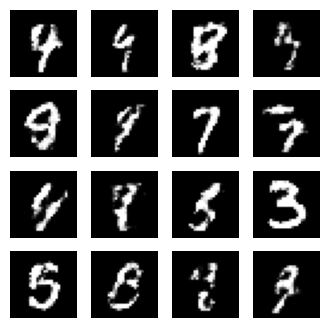

Epoch 461, Discriminator Loss: 0.2691313624382019, Generator Loss: 2.56601619720459
Epoch 462, Discriminator Loss: 0.3096277713775635, Generator Loss: 1.9593873023986816
Epoch 463, Discriminator Loss: 0.30571919679641724, Generator Loss: 2.73089599609375
Epoch 464, Discriminator Loss: 0.35150277614593506, Generator Loss: 2.896458625793457
Epoch 465, Discriminator Loss: 0.3221427798271179, Generator Loss: 2.321772336959839
Epoch 466, Discriminator Loss: 0.20896531641483307, Generator Loss: 2.4795918464660645
Epoch 467, Discriminator Loss: 0.33433806896209717, Generator Loss: 1.958569049835205
Epoch 468, Discriminator Loss: 0.24017614126205444, Generator Loss: 2.972787380218506
Epoch 469, Discriminator Loss: 0.20180341601371765, Generator Loss: 2.9791359901428223
Epoch 470, Discriminator Loss: 0.39534705877304077, Generator Loss: 2.4807772636413574


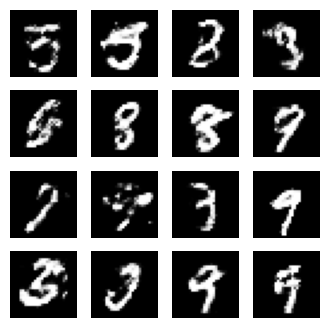

Epoch 471, Discriminator Loss: 0.33849474787712097, Generator Loss: 1.9031310081481934
Epoch 472, Discriminator Loss: 0.287002831697464, Generator Loss: 2.4602718353271484
Epoch 473, Discriminator Loss: 0.31442081928253174, Generator Loss: 2.7269644737243652
Epoch 474, Discriminator Loss: 0.40892353653907776, Generator Loss: 2.3079521656036377
Epoch 475, Discriminator Loss: 0.31057795882225037, Generator Loss: 2.507463216781616
Epoch 476, Discriminator Loss: 0.2272690236568451, Generator Loss: 3.126232147216797
Epoch 477, Discriminator Loss: 0.3148491382598877, Generator Loss: 2.571442127227783
Epoch 478, Discriminator Loss: 0.2503039836883545, Generator Loss: 2.4044432640075684
Epoch 479, Discriminator Loss: 0.32414254546165466, Generator Loss: 2.56330943107605
Epoch 480, Discriminator Loss: 0.21942365169525146, Generator Loss: 2.629418134689331


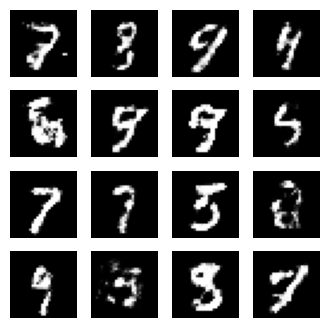

Epoch 481, Discriminator Loss: 0.2516917288303375, Generator Loss: 3.097780466079712
Epoch 482, Discriminator Loss: 0.2025209218263626, Generator Loss: 2.5053672790527344
Epoch 483, Discriminator Loss: 0.26077091693878174, Generator Loss: 3.392568826675415
Epoch 484, Discriminator Loss: 0.23859566450119019, Generator Loss: 2.747713088989258
Epoch 485, Discriminator Loss: 0.2478383332490921, Generator Loss: 3.279731273651123
Epoch 486, Discriminator Loss: 0.31813883781433105, Generator Loss: 1.903022289276123
Epoch 487, Discriminator Loss: 0.21404221653938293, Generator Loss: 2.9054880142211914
Epoch 488, Discriminator Loss: 0.3136352300643921, Generator Loss: 2.3709402084350586
Epoch 489, Discriminator Loss: 0.20564201474189758, Generator Loss: 2.314617872238159
Epoch 490, Discriminator Loss: 0.2768501341342926, Generator Loss: 2.9469845294952393


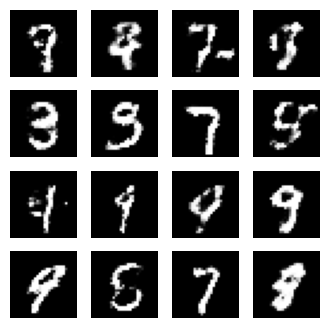

Epoch 491, Discriminator Loss: 0.21591174602508545, Generator Loss: 2.3137047290802
Epoch 492, Discriminator Loss: 0.3499337434768677, Generator Loss: 2.007319450378418
Epoch 493, Discriminator Loss: 0.27947235107421875, Generator Loss: 2.566168785095215
Epoch 494, Discriminator Loss: 0.28782153129577637, Generator Loss: 2.565793752670288
Epoch 495, Discriminator Loss: 0.2551058232784271, Generator Loss: 2.4483633041381836
Epoch 496, Discriminator Loss: 0.19235587120056152, Generator Loss: 2.7081072330474854
Epoch 497, Discriminator Loss: 0.20758533477783203, Generator Loss: 3.0431742668151855
Epoch 498, Discriminator Loss: 0.306765615940094, Generator Loss: 3.3321495056152344
Epoch 499, Discriminator Loss: 0.27268853783607483, Generator Loss: 3.1861748695373535
Epoch 500, Discriminator Loss: 0.2453959435224533, Generator Loss: 2.140204668045044


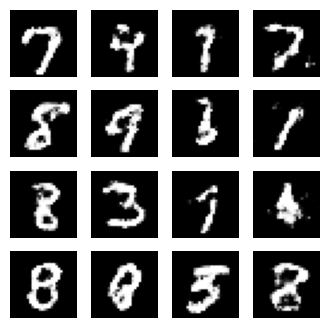

Epoch 501, Discriminator Loss: 0.25446492433547974, Generator Loss: 2.568260669708252
Epoch 502, Discriminator Loss: 0.26855039596557617, Generator Loss: 2.7647969722747803
Epoch 503, Discriminator Loss: 0.3299146890640259, Generator Loss: 2.716691017150879
Epoch 504, Discriminator Loss: 0.27535074949264526, Generator Loss: 2.649796485900879
Epoch 505, Discriminator Loss: 0.2915318012237549, Generator Loss: 2.276325225830078
Epoch 506, Discriminator Loss: 0.2795177698135376, Generator Loss: 2.4464802742004395
Epoch 507, Discriminator Loss: 0.3278930187225342, Generator Loss: 2.4196224212646484
Epoch 508, Discriminator Loss: 0.1777184158563614, Generator Loss: 2.8446006774902344
Epoch 509, Discriminator Loss: 0.2505246102809906, Generator Loss: 2.664940357208252
Epoch 510, Discriminator Loss: 0.23947475850582123, Generator Loss: 2.8176803588867188


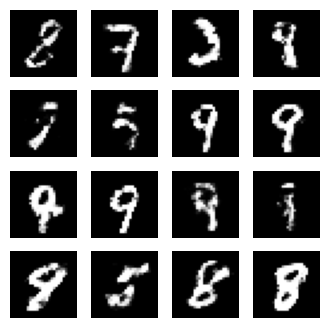

Epoch 511, Discriminator Loss: 0.38351380825042725, Generator Loss: 2.2106738090515137
Epoch 512, Discriminator Loss: 0.327738881111145, Generator Loss: 2.776967763900757
Epoch 513, Discriminator Loss: 0.256560742855072, Generator Loss: 2.312591075897217
Epoch 514, Discriminator Loss: 0.23181094229221344, Generator Loss: 3.0329411029815674
Epoch 515, Discriminator Loss: 0.18934684991836548, Generator Loss: 3.016982078552246
Epoch 516, Discriminator Loss: 0.25285395979881287, Generator Loss: 2.1640305519104004
Epoch 517, Discriminator Loss: 0.28975701332092285, Generator Loss: 2.1042122840881348
Epoch 518, Discriminator Loss: 0.1935945302248001, Generator Loss: 2.573557138442993
Epoch 519, Discriminator Loss: 0.2596794366836548, Generator Loss: 2.585749387741089
Epoch 520, Discriminator Loss: 0.22772490978240967, Generator Loss: 2.1402182579040527


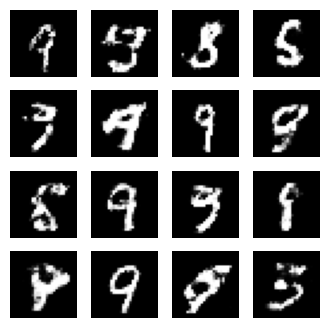

Epoch 521, Discriminator Loss: 0.23590421676635742, Generator Loss: 2.3053276538848877
Epoch 522, Discriminator Loss: 0.3819461464881897, Generator Loss: 2.9887471199035645
Epoch 523, Discriminator Loss: 0.24150541424751282, Generator Loss: 2.582514524459839
Epoch 524, Discriminator Loss: 0.2660861015319824, Generator Loss: 3.0745670795440674
Epoch 525, Discriminator Loss: 0.31037139892578125, Generator Loss: 2.628506898880005
Epoch 526, Discriminator Loss: 0.5269240140914917, Generator Loss: 2.236438751220703
Epoch 527, Discriminator Loss: 0.3672962784767151, Generator Loss: 2.2427244186401367
Epoch 528, Discriminator Loss: 0.20831260085105896, Generator Loss: 2.7477452754974365
Epoch 529, Discriminator Loss: 0.35681626200675964, Generator Loss: 2.1963915824890137
Epoch 530, Discriminator Loss: 0.269773006439209, Generator Loss: 2.82938289642334


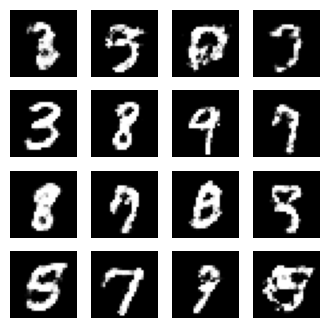

Epoch 531, Discriminator Loss: 0.19325590133666992, Generator Loss: 3.2687437534332275
Epoch 532, Discriminator Loss: 0.29756981134414673, Generator Loss: 2.621201276779175
Epoch 533, Discriminator Loss: 0.2436831146478653, Generator Loss: 2.88863205909729
Epoch 534, Discriminator Loss: 0.29668617248535156, Generator Loss: 2.2976887226104736
Epoch 535, Discriminator Loss: 0.2857533395290375, Generator Loss: 2.559481620788574
Epoch 536, Discriminator Loss: 0.22922995686531067, Generator Loss: 3.0507874488830566
Epoch 537, Discriminator Loss: 0.22671228647232056, Generator Loss: 2.709871292114258
Epoch 538, Discriminator Loss: 0.2636365592479706, Generator Loss: 2.593583106994629
Epoch 539, Discriminator Loss: 0.21367716789245605, Generator Loss: 2.8711884021759033
Epoch 540, Discriminator Loss: 0.225548654794693, Generator Loss: 2.5718724727630615


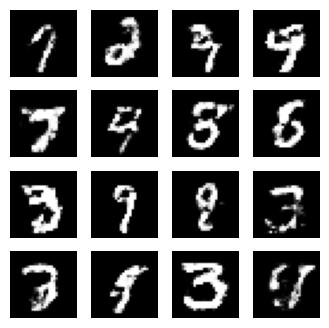

Epoch 541, Discriminator Loss: 0.22180020809173584, Generator Loss: 2.2872376441955566
Epoch 542, Discriminator Loss: 0.17908382415771484, Generator Loss: 2.8730127811431885
Epoch 543, Discriminator Loss: 0.3276134729385376, Generator Loss: 1.900219202041626
Epoch 544, Discriminator Loss: 0.2371765673160553, Generator Loss: 2.189631462097168
Epoch 545, Discriminator Loss: 0.21755260229110718, Generator Loss: 2.588136672973633
Epoch 546, Discriminator Loss: 0.22545623779296875, Generator Loss: 2.715857744216919
Epoch 547, Discriminator Loss: 0.22206851840019226, Generator Loss: 2.550845146179199
Epoch 548, Discriminator Loss: 0.3054337501525879, Generator Loss: 2.800640821456909
Epoch 549, Discriminator Loss: 0.24334527552127838, Generator Loss: 2.542160749435425
Epoch 550, Discriminator Loss: 0.31853288412094116, Generator Loss: 2.224423408508301


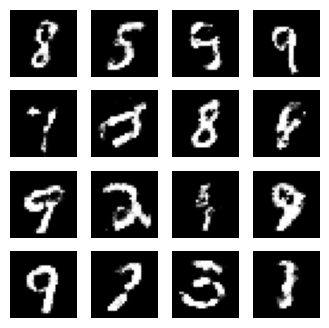

Epoch 551, Discriminator Loss: 0.30953165888786316, Generator Loss: 2.557621955871582
Epoch 552, Discriminator Loss: 0.37663114070892334, Generator Loss: 2.5410046577453613
Epoch 553, Discriminator Loss: 0.2887864112854004, Generator Loss: 2.8309407234191895
Epoch 554, Discriminator Loss: 0.19320236146450043, Generator Loss: 2.201014518737793
Epoch 555, Discriminator Loss: 0.17950360476970673, Generator Loss: 2.921238899230957
Epoch 556, Discriminator Loss: 0.274221271276474, Generator Loss: 2.4771745204925537
Epoch 557, Discriminator Loss: 0.3590881824493408, Generator Loss: 2.6667559146881104
Epoch 558, Discriminator Loss: 0.23297451436519623, Generator Loss: 2.585498332977295
Epoch 559, Discriminator Loss: 0.29413411021232605, Generator Loss: 2.789958953857422
Epoch 560, Discriminator Loss: 0.29764699935913086, Generator Loss: 2.318835973739624


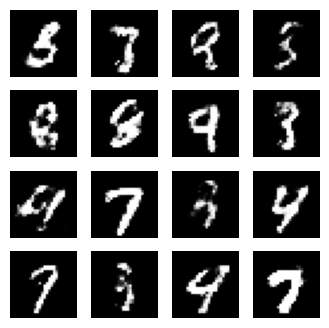

Epoch 561, Discriminator Loss: 0.32163071632385254, Generator Loss: 2.7829957008361816
Epoch 562, Discriminator Loss: 0.2920348346233368, Generator Loss: 2.650329351425171
Epoch 563, Discriminator Loss: 0.39113759994506836, Generator Loss: 2.405451774597168
Epoch 564, Discriminator Loss: 0.26871076226234436, Generator Loss: 2.811223030090332
Epoch 565, Discriminator Loss: 0.20755022764205933, Generator Loss: 2.3491883277893066
Epoch 566, Discriminator Loss: 0.4187614917755127, Generator Loss: 2.280839443206787
Epoch 567, Discriminator Loss: 0.44160592555999756, Generator Loss: 2.45810604095459
Epoch 568, Discriminator Loss: 0.3060300350189209, Generator Loss: 2.023209571838379
Epoch 569, Discriminator Loss: 0.3755478858947754, Generator Loss: 3.043405771255493
Epoch 570, Discriminator Loss: 0.2735399603843689, Generator Loss: 2.6505773067474365


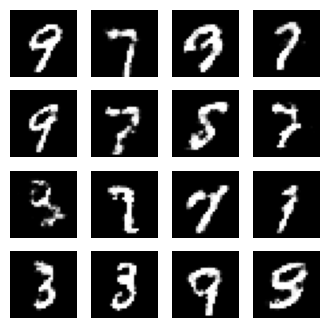

Epoch 571, Discriminator Loss: 0.2572318911552429, Generator Loss: 2.5531983375549316
Epoch 572, Discriminator Loss: 0.20380757749080658, Generator Loss: 2.876544713973999
Epoch 573, Discriminator Loss: 0.2758607268333435, Generator Loss: 2.298509120941162
Epoch 574, Discriminator Loss: 0.2408091276884079, Generator Loss: 2.5102434158325195
Epoch 575, Discriminator Loss: 0.29284408688545227, Generator Loss: 2.9593863487243652
Epoch 576, Discriminator Loss: 0.23094457387924194, Generator Loss: 2.492841958999634
Epoch 577, Discriminator Loss: 0.2205696403980255, Generator Loss: 2.9135067462921143
Epoch 578, Discriminator Loss: 0.312481164932251, Generator Loss: 2.5803422927856445
Epoch 579, Discriminator Loss: 0.1450459212064743, Generator Loss: 3.122814655303955
Epoch 580, Discriminator Loss: 0.2911491096019745, Generator Loss: 2.4871435165405273


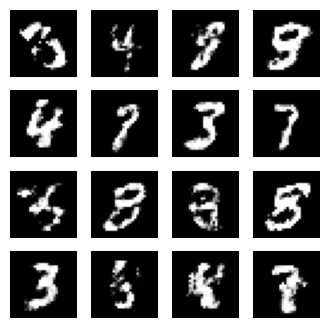

Epoch 581, Discriminator Loss: 0.21538269519805908, Generator Loss: 2.7539236545562744
Epoch 582, Discriminator Loss: 0.38125360012054443, Generator Loss: 2.224514961242676
Epoch 583, Discriminator Loss: 0.18074366450309753, Generator Loss: 3.165494918823242
Epoch 584, Discriminator Loss: 0.2832190692424774, Generator Loss: 2.1533567905426025
Epoch 585, Discriminator Loss: 0.24474599957466125, Generator Loss: 2.9158785343170166
Epoch 586, Discriminator Loss: 0.27102333307266235, Generator Loss: 2.429161548614502
Epoch 587, Discriminator Loss: 0.3422481119632721, Generator Loss: 2.431281089782715
Epoch 588, Discriminator Loss: 0.23104719817638397, Generator Loss: 2.8251309394836426
Epoch 589, Discriminator Loss: 0.34779417514801025, Generator Loss: 2.401704788208008
Epoch 590, Discriminator Loss: 0.36761048436164856, Generator Loss: 2.084779739379883


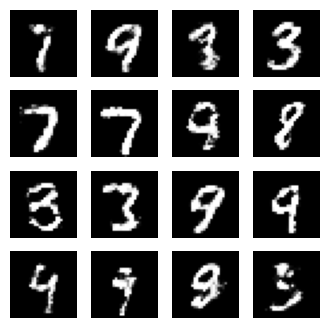

Epoch 591, Discriminator Loss: 0.22005462646484375, Generator Loss: 2.9823920726776123
Epoch 592, Discriminator Loss: 0.24022626876831055, Generator Loss: 2.636051654815674
Epoch 593, Discriminator Loss: 0.33585378527641296, Generator Loss: 2.6265034675598145
Epoch 594, Discriminator Loss: 0.2927451431751251, Generator Loss: 2.566053867340088
Epoch 595, Discriminator Loss: 0.35134050250053406, Generator Loss: 2.6093549728393555
Epoch 596, Discriminator Loss: 0.2539319097995758, Generator Loss: 2.293149471282959
Epoch 597, Discriminator Loss: 0.2929237186908722, Generator Loss: 2.6173229217529297
Epoch 598, Discriminator Loss: 0.23269468545913696, Generator Loss: 2.4185023307800293
Epoch 599, Discriminator Loss: 0.2582143545150757, Generator Loss: 2.2596054077148438
Epoch 600, Discriminator Loss: 0.27604568004608154, Generator Loss: 2.6225745677948


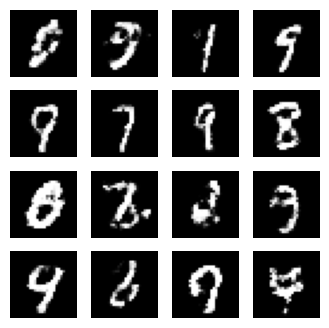

Epoch 601, Discriminator Loss: 0.2804867625236511, Generator Loss: 2.461297035217285
Epoch 602, Discriminator Loss: 0.23073717951774597, Generator Loss: 2.9163856506347656
Epoch 603, Discriminator Loss: 0.3814653754234314, Generator Loss: 2.693593740463257
Epoch 604, Discriminator Loss: 0.29257112741470337, Generator Loss: 3.120913505554199
Epoch 605, Discriminator Loss: 0.16774019598960876, Generator Loss: 2.704578399658203
Epoch 606, Discriminator Loss: 0.27865612506866455, Generator Loss: 2.1693732738494873
Epoch 607, Discriminator Loss: 0.20257163047790527, Generator Loss: 2.7151498794555664
Epoch 608, Discriminator Loss: 0.33314049243927, Generator Loss: 2.170867681503296
Epoch 609, Discriminator Loss: 0.2422209531068802, Generator Loss: 2.5789976119995117
Epoch 610, Discriminator Loss: 0.3052603006362915, Generator Loss: 2.6023669242858887


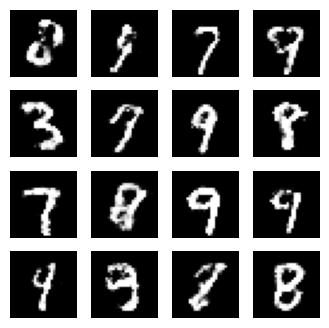

Epoch 611, Discriminator Loss: 0.29114943742752075, Generator Loss: 2.3933300971984863
Epoch 612, Discriminator Loss: 0.3272113800048828, Generator Loss: 2.3571293354034424
Epoch 613, Discriminator Loss: 0.25367963314056396, Generator Loss: 2.667677640914917
Epoch 614, Discriminator Loss: 0.35876742005348206, Generator Loss: 2.329422950744629
Epoch 615, Discriminator Loss: 0.2710058391094208, Generator Loss: 2.423579454421997
Epoch 616, Discriminator Loss: 0.24565398693084717, Generator Loss: 2.494854211807251
Epoch 617, Discriminator Loss: 0.2930823564529419, Generator Loss: 2.922720432281494
Epoch 618, Discriminator Loss: 0.3671606183052063, Generator Loss: 2.211322546005249
Epoch 619, Discriminator Loss: 0.24229495227336884, Generator Loss: 2.5129237174987793
Epoch 620, Discriminator Loss: 0.23108181357383728, Generator Loss: 2.5508921146392822


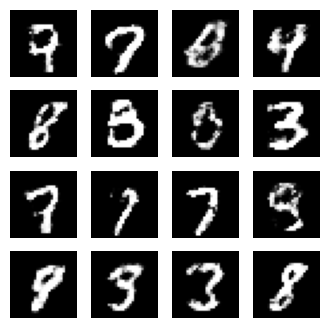

Epoch 621, Discriminator Loss: 0.30983251333236694, Generator Loss: 2.624130964279175
Epoch 622, Discriminator Loss: 0.26324141025543213, Generator Loss: 2.454515218734741
Epoch 623, Discriminator Loss: 0.3871367871761322, Generator Loss: 2.3121705055236816
Epoch 624, Discriminator Loss: 0.29547569155693054, Generator Loss: 2.6450376510620117
Epoch 625, Discriminator Loss: 0.3174525797367096, Generator Loss: 2.3755273818969727
Epoch 626, Discriminator Loss: 0.26102495193481445, Generator Loss: 2.4204602241516113
Epoch 627, Discriminator Loss: 0.35007035732269287, Generator Loss: 1.9103950262069702
Epoch 628, Discriminator Loss: 0.3198246955871582, Generator Loss: 2.2294602394104004
Epoch 629, Discriminator Loss: 0.2687130868434906, Generator Loss: 2.262146472930908
Epoch 630, Discriminator Loss: 0.3264894187450409, Generator Loss: 2.5740795135498047


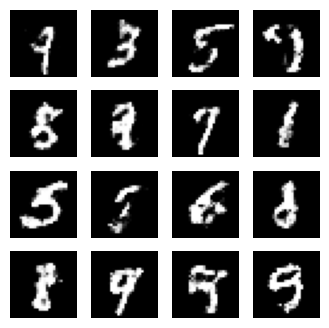

Epoch 631, Discriminator Loss: 0.31035879254341125, Generator Loss: 2.4415130615234375
Epoch 632, Discriminator Loss: 0.3140215575695038, Generator Loss: 2.4222588539123535
Epoch 633, Discriminator Loss: 0.29469072818756104, Generator Loss: 2.843942642211914
Epoch 634, Discriminator Loss: 0.1745024472475052, Generator Loss: 2.710681915283203
Epoch 635, Discriminator Loss: 0.31818997859954834, Generator Loss: 2.651918411254883
Epoch 636, Discriminator Loss: 0.3105730414390564, Generator Loss: 2.0997471809387207
Epoch 637, Discriminator Loss: 0.2543812692165375, Generator Loss: 2.2685842514038086
Epoch 638, Discriminator Loss: 0.2825643718242645, Generator Loss: 2.61386775970459
Epoch 639, Discriminator Loss: 0.2239636778831482, Generator Loss: 2.7227020263671875
Epoch 640, Discriminator Loss: 0.262999564409256, Generator Loss: 2.920710563659668


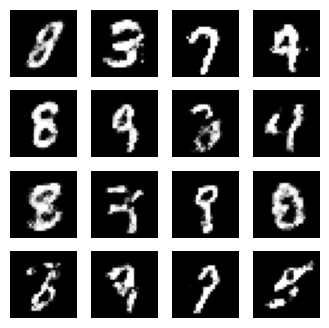

Epoch 641, Discriminator Loss: 0.25910741090774536, Generator Loss: 2.574734687805176
Epoch 642, Discriminator Loss: 0.19288131594657898, Generator Loss: 2.83571195602417
Epoch 643, Discriminator Loss: 0.3005635738372803, Generator Loss: 3.086358070373535
Epoch 644, Discriminator Loss: 0.2880556285381317, Generator Loss: 2.5217509269714355
Epoch 645, Discriminator Loss: 0.21087616682052612, Generator Loss: 2.6830532550811768
Epoch 646, Discriminator Loss: 0.1655920296907425, Generator Loss: 3.195042133331299
Epoch 647, Discriminator Loss: 0.2780022919178009, Generator Loss: 2.4505109786987305
Epoch 648, Discriminator Loss: 0.2724127173423767, Generator Loss: 2.399008274078369
Epoch 649, Discriminator Loss: 0.2697020471096039, Generator Loss: 2.8649439811706543
Epoch 650, Discriminator Loss: 0.34605473279953003, Generator Loss: 2.4765400886535645


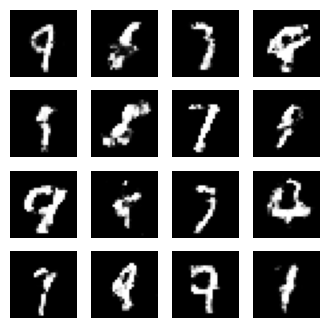

Epoch 651, Discriminator Loss: 0.3576332628726959, Generator Loss: 2.700929880142212
Epoch 652, Discriminator Loss: 0.2501615583896637, Generator Loss: 2.6078591346740723
Epoch 653, Discriminator Loss: 0.327016144990921, Generator Loss: 2.41800856590271
Epoch 654, Discriminator Loss: 0.24924680590629578, Generator Loss: 2.3806562423706055
Epoch 655, Discriminator Loss: 0.2517557144165039, Generator Loss: 2.9935083389282227
Epoch 656, Discriminator Loss: 0.27238407731056213, Generator Loss: 2.7348923683166504
Epoch 657, Discriminator Loss: 0.34649986028671265, Generator Loss: 2.1550145149230957
Epoch 658, Discriminator Loss: 0.2624932825565338, Generator Loss: 2.3128209114074707
Epoch 659, Discriminator Loss: 0.25195443630218506, Generator Loss: 2.569448947906494
Epoch 660, Discriminator Loss: 0.3177131414413452, Generator Loss: 2.2299513816833496


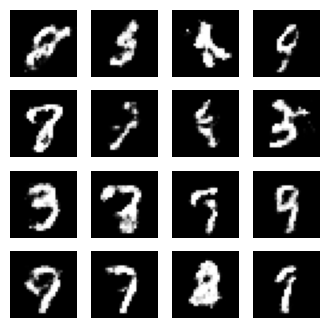

Epoch 661, Discriminator Loss: 0.4262392520904541, Generator Loss: 1.6204092502593994
Epoch 662, Discriminator Loss: 0.21319839358329773, Generator Loss: 2.5418190956115723
Epoch 663, Discriminator Loss: 0.2937971353530884, Generator Loss: 2.5644350051879883
Epoch 664, Discriminator Loss: 0.20029893517494202, Generator Loss: 2.503652572631836
Epoch 665, Discriminator Loss: 0.3303471505641937, Generator Loss: 2.0823380947113037
Epoch 666, Discriminator Loss: 0.24578526616096497, Generator Loss: 2.330047845840454
Epoch 667, Discriminator Loss: 0.19604560732841492, Generator Loss: 2.502915382385254
Epoch 668, Discriminator Loss: 0.3537827134132385, Generator Loss: 1.9498519897460938
Epoch 669, Discriminator Loss: 0.2273726612329483, Generator Loss: 2.7725839614868164
Epoch 670, Discriminator Loss: 0.3198182284832001, Generator Loss: 2.4279606342315674


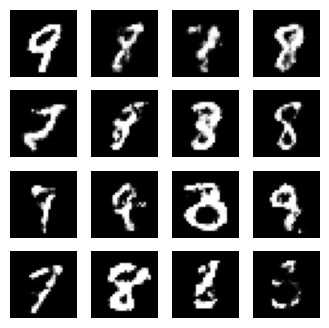

Epoch 671, Discriminator Loss: 0.24098452925682068, Generator Loss: 2.4158895015716553
Epoch 672, Discriminator Loss: 0.18545830249786377, Generator Loss: 2.8346898555755615
Epoch 673, Discriminator Loss: 0.3046446442604065, Generator Loss: 2.2121737003326416
Epoch 674, Discriminator Loss: 0.24111828207969666, Generator Loss: 2.1421306133270264
Epoch 675, Discriminator Loss: 0.249564528465271, Generator Loss: 2.3685247898101807
Epoch 676, Discriminator Loss: 0.34210383892059326, Generator Loss: 2.2808055877685547
Epoch 677, Discriminator Loss: 0.3917204737663269, Generator Loss: 1.839989185333252
Epoch 678, Discriminator Loss: 0.26825419068336487, Generator Loss: 2.4847137928009033
Epoch 679, Discriminator Loss: 0.22703352570533752, Generator Loss: 2.681668519973755
Epoch 680, Discriminator Loss: 0.25593093037605286, Generator Loss: 2.1736044883728027


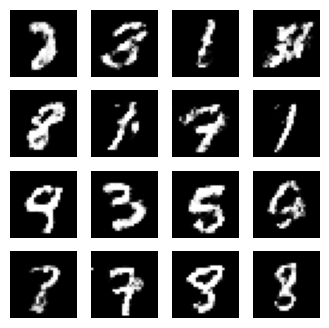

Epoch 681, Discriminator Loss: 0.23828592896461487, Generator Loss: 2.2116219997406006
Epoch 682, Discriminator Loss: 0.3110765218734741, Generator Loss: 2.2578556537628174
Epoch 683, Discriminator Loss: 0.34728145599365234, Generator Loss: 2.74981689453125
Epoch 684, Discriminator Loss: 0.305023729801178, Generator Loss: 2.3520865440368652
Epoch 685, Discriminator Loss: 0.27537477016448975, Generator Loss: 2.7481179237365723
Epoch 686, Discriminator Loss: 0.27253398299217224, Generator Loss: 2.7012205123901367
Epoch 687, Discriminator Loss: 0.3885025978088379, Generator Loss: 2.336968183517456
Epoch 688, Discriminator Loss: 0.32561320066452026, Generator Loss: 2.356271266937256
Epoch 689, Discriminator Loss: 0.30919939279556274, Generator Loss: 1.9229483604431152
Epoch 690, Discriminator Loss: 0.3975238502025604, Generator Loss: 2.1371665000915527


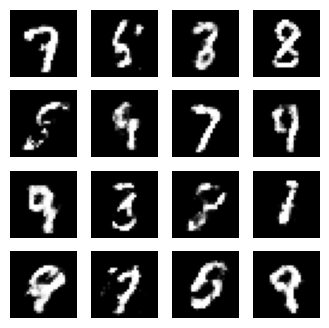

Epoch 691, Discriminator Loss: 0.2162393480539322, Generator Loss: 2.8848876953125
Epoch 692, Discriminator Loss: 0.28922039270401, Generator Loss: 1.9941484928131104
Epoch 693, Discriminator Loss: 0.28599753975868225, Generator Loss: 3.121891975402832
Epoch 694, Discriminator Loss: 0.3131427466869354, Generator Loss: 2.628664970397949
Epoch 695, Discriminator Loss: 0.3365202844142914, Generator Loss: 2.476299524307251
Epoch 696, Discriminator Loss: 0.3677728772163391, Generator Loss: 2.2843642234802246
Epoch 697, Discriminator Loss: 0.27005451917648315, Generator Loss: 2.5501973628997803
Epoch 698, Discriminator Loss: 0.25430727005004883, Generator Loss: 2.815359592437744
Epoch 699, Discriminator Loss: 0.3370022177696228, Generator Loss: 2.467587471008301
Epoch 700, Discriminator Loss: 0.2184656262397766, Generator Loss: 2.260990619659424


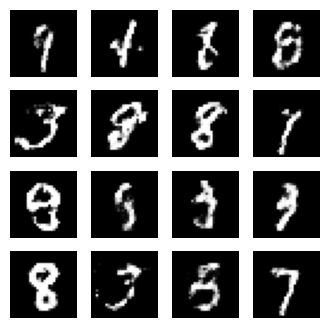

Epoch 701, Discriminator Loss: 0.3017924427986145, Generator Loss: 2.3975157737731934
Epoch 702, Discriminator Loss: 0.23508277535438538, Generator Loss: 2.7491633892059326
Epoch 703, Discriminator Loss: 0.36624273657798767, Generator Loss: 2.296889305114746
Epoch 704, Discriminator Loss: 0.2479747086763382, Generator Loss: 2.5027382373809814
Epoch 705, Discriminator Loss: 0.2512557804584503, Generator Loss: 2.3998641967773438
Epoch 706, Discriminator Loss: 0.23314428329467773, Generator Loss: 2.6950924396514893
Epoch 707, Discriminator Loss: 0.28193533420562744, Generator Loss: 2.7351927757263184
Epoch 708, Discriminator Loss: 0.3531663417816162, Generator Loss: 3.204878091812134
Epoch 709, Discriminator Loss: 0.336536705493927, Generator Loss: 2.479185104370117
Epoch 710, Discriminator Loss: 0.25775060057640076, Generator Loss: 2.3495097160339355


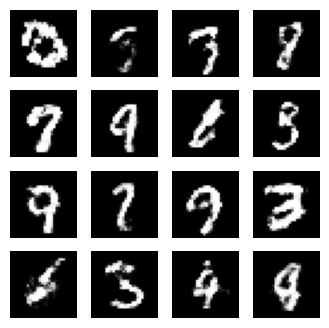

Epoch 711, Discriminator Loss: 0.42108750343322754, Generator Loss: 2.568816661834717
Epoch 712, Discriminator Loss: 0.29376503825187683, Generator Loss: 2.6522135734558105
Epoch 713, Discriminator Loss: 0.3042161464691162, Generator Loss: 2.584505319595337
Epoch 714, Discriminator Loss: 0.21787187457084656, Generator Loss: 2.715261936187744
Epoch 715, Discriminator Loss: 0.3733016848564148, Generator Loss: 2.567838191986084
Epoch 716, Discriminator Loss: 0.3091871440410614, Generator Loss: 2.3243186473846436
Epoch 717, Discriminator Loss: 0.1829393208026886, Generator Loss: 3.0109901428222656
Epoch 718, Discriminator Loss: 0.34963512420654297, Generator Loss: 2.011852741241455
Epoch 719, Discriminator Loss: 0.23204633593559265, Generator Loss: 2.8108110427856445
Epoch 720, Discriminator Loss: 0.28747016191482544, Generator Loss: 2.9302687644958496


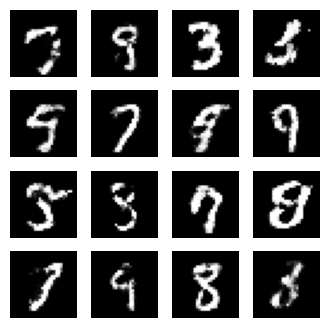

Epoch 721, Discriminator Loss: 0.2390691041946411, Generator Loss: 2.365388870239258
Epoch 722, Discriminator Loss: 0.39465171098709106, Generator Loss: 1.966648817062378
Epoch 723, Discriminator Loss: 0.3378868103027344, Generator Loss: 2.769962787628174
Epoch 724, Discriminator Loss: 0.24692772328853607, Generator Loss: 2.4928274154663086
Epoch 725, Discriminator Loss: 0.40763968229293823, Generator Loss: 2.5751447677612305
Epoch 726, Discriminator Loss: 0.24797680974006653, Generator Loss: 2.1538116931915283
Epoch 727, Discriminator Loss: 0.38002997636795044, Generator Loss: 2.306182861328125
Epoch 728, Discriminator Loss: 0.3390939235687256, Generator Loss: 2.163187026977539
Epoch 729, Discriminator Loss: 0.23186883330345154, Generator Loss: 2.883993148803711
Epoch 730, Discriminator Loss: 0.2910146713256836, Generator Loss: 2.1554596424102783


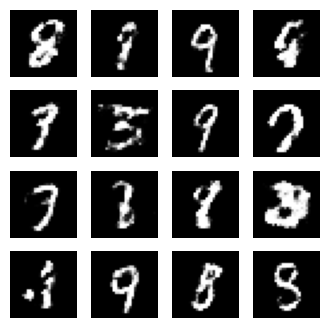

Epoch 731, Discriminator Loss: 0.3395053744316101, Generator Loss: 2.2429451942443848
Epoch 732, Discriminator Loss: 0.3236166834831238, Generator Loss: 2.103520393371582
Epoch 733, Discriminator Loss: 0.2932621240615845, Generator Loss: 2.474562644958496
Epoch 734, Discriminator Loss: 0.3044910728931427, Generator Loss: 2.5103964805603027
Epoch 735, Discriminator Loss: 0.35304978489875793, Generator Loss: 1.8826234340667725
Epoch 736, Discriminator Loss: 0.24086809158325195, Generator Loss: 3.1138041019439697
Epoch 737, Discriminator Loss: 0.2757701277732849, Generator Loss: 2.6181838512420654
Epoch 738, Discriminator Loss: 0.2963201701641083, Generator Loss: 2.884037733078003
Epoch 739, Discriminator Loss: 0.3500289022922516, Generator Loss: 2.3718621730804443
Epoch 740, Discriminator Loss: 0.21060025691986084, Generator Loss: 2.7855453491210938


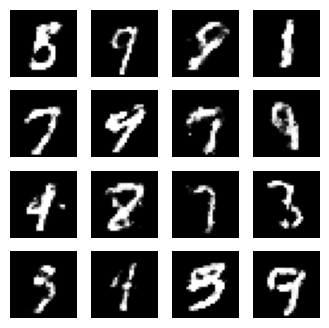

Epoch 741, Discriminator Loss: 0.3561035394668579, Generator Loss: 2.348778009414673
Epoch 742, Discriminator Loss: 0.404583603143692, Generator Loss: 2.3512773513793945
Epoch 743, Discriminator Loss: 0.2435724437236786, Generator Loss: 2.315445899963379
Epoch 744, Discriminator Loss: 0.2814871072769165, Generator Loss: 2.036241054534912
Epoch 745, Discriminator Loss: 0.24852922558784485, Generator Loss: 2.932187795639038
Epoch 746, Discriminator Loss: 0.3246961236000061, Generator Loss: 2.3561899662017822
Epoch 747, Discriminator Loss: 0.26380622386932373, Generator Loss: 2.4645516872406006
Epoch 748, Discriminator Loss: 0.268340528011322, Generator Loss: 2.811906099319458
Epoch 749, Discriminator Loss: 0.3056296706199646, Generator Loss: 1.9722363948822021
Epoch 750, Discriminator Loss: 0.2643232047557831, Generator Loss: 2.4242336750030518


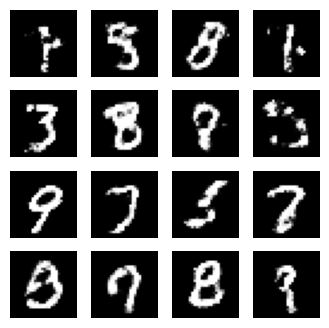

Epoch 751, Discriminator Loss: 0.21427854895591736, Generator Loss: 2.796513080596924
Epoch 752, Discriminator Loss: 0.2750079333782196, Generator Loss: 2.6267218589782715
Epoch 753, Discriminator Loss: 0.2159683108329773, Generator Loss: 2.2495992183685303
Epoch 754, Discriminator Loss: 0.2854453921318054, Generator Loss: 2.3641464710235596
Epoch 755, Discriminator Loss: 0.3180345892906189, Generator Loss: 2.1795830726623535
Epoch 756, Discriminator Loss: 0.3387652635574341, Generator Loss: 2.647437572479248
Epoch 757, Discriminator Loss: 0.281191349029541, Generator Loss: 2.448930501937866
Epoch 758, Discriminator Loss: 0.26347944140434265, Generator Loss: 2.649280071258545
Epoch 759, Discriminator Loss: 0.26621586084365845, Generator Loss: 2.6680209636688232
Epoch 760, Discriminator Loss: 0.30447012186050415, Generator Loss: 2.403327703475952


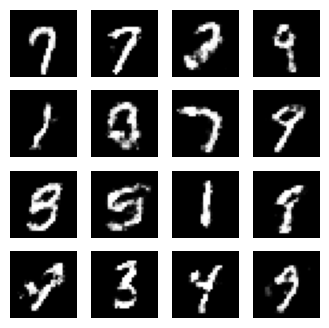

Epoch 761, Discriminator Loss: 0.34784382581710815, Generator Loss: 2.1746277809143066
Epoch 762, Discriminator Loss: 0.3967006504535675, Generator Loss: 2.6775588989257812
Epoch 763, Discriminator Loss: 0.32139331102371216, Generator Loss: 2.4093520641326904
Epoch 764, Discriminator Loss: 0.24538862705230713, Generator Loss: 2.831890344619751
Epoch 765, Discriminator Loss: 0.2669712007045746, Generator Loss: 2.328209400177002
Epoch 766, Discriminator Loss: 0.31117355823516846, Generator Loss: 2.2737812995910645
Epoch 767, Discriminator Loss: 0.29947662353515625, Generator Loss: 2.5978283882141113
Epoch 768, Discriminator Loss: 0.3066748082637787, Generator Loss: 2.5760295391082764
Epoch 769, Discriminator Loss: 0.38777294754981995, Generator Loss: 1.8085741996765137
Epoch 770, Discriminator Loss: 0.2667566239833832, Generator Loss: 2.6442341804504395


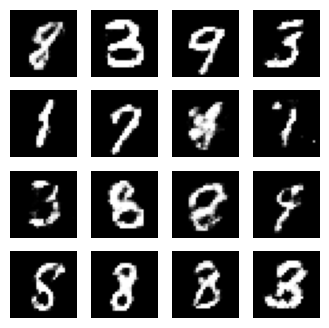

Epoch 771, Discriminator Loss: 0.3012658953666687, Generator Loss: 2.8481996059417725
Epoch 772, Discriminator Loss: 0.37848255038261414, Generator Loss: 2.3055195808410645
Epoch 773, Discriminator Loss: 0.29899078607559204, Generator Loss: 2.5932958126068115
Epoch 774, Discriminator Loss: 0.2566377520561218, Generator Loss: 2.3908917903900146
Epoch 775, Discriminator Loss: 0.23683902621269226, Generator Loss: 2.439368724822998
Epoch 776, Discriminator Loss: 0.3067505955696106, Generator Loss: 2.0585694313049316
Epoch 777, Discriminator Loss: 0.21212323009967804, Generator Loss: 2.2973098754882812
Epoch 778, Discriminator Loss: 0.2947321832180023, Generator Loss: 2.28165602684021
Epoch 779, Discriminator Loss: 0.3345513343811035, Generator Loss: 2.6931276321411133
Epoch 780, Discriminator Loss: 0.3214845657348633, Generator Loss: 2.5587143898010254


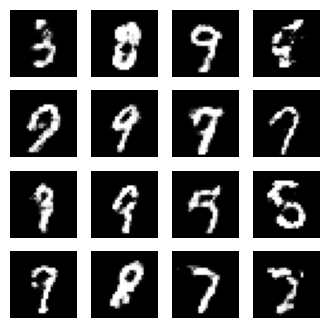

Epoch 781, Discriminator Loss: 0.3781623840332031, Generator Loss: 2.6177921295166016
Epoch 782, Discriminator Loss: 0.2868943512439728, Generator Loss: 2.1813831329345703
Epoch 783, Discriminator Loss: 0.3047417402267456, Generator Loss: 2.0068607330322266
Epoch 784, Discriminator Loss: 0.2338162064552307, Generator Loss: 2.775240421295166
Epoch 785, Discriminator Loss: 0.2720205783843994, Generator Loss: 2.629096508026123
Epoch 786, Discriminator Loss: 0.39991533756256104, Generator Loss: 2.5871188640594482
Epoch 787, Discriminator Loss: 0.3025999069213867, Generator Loss: 2.504450798034668
Epoch 788, Discriminator Loss: 0.3243001103401184, Generator Loss: 2.1504838466644287
Epoch 789, Discriminator Loss: 0.31565776467323303, Generator Loss: 1.9509832859039307
Epoch 790, Discriminator Loss: 0.30509719252586365, Generator Loss: 2.360748291015625


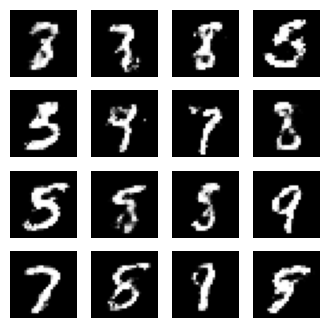

Epoch 791, Discriminator Loss: 0.2425626963376999, Generator Loss: 1.973536729812622
Epoch 792, Discriminator Loss: 0.22581782937049866, Generator Loss: 2.9794962406158447
Epoch 793, Discriminator Loss: 0.3180476427078247, Generator Loss: 2.6377062797546387
Epoch 794, Discriminator Loss: 0.18670330941677094, Generator Loss: 2.7127633094787598
Epoch 795, Discriminator Loss: 0.32783305644989014, Generator Loss: 2.142920970916748
Epoch 796, Discriminator Loss: 0.2300528883934021, Generator Loss: 2.5255889892578125
Epoch 797, Discriminator Loss: 0.33053308725357056, Generator Loss: 2.5045275688171387
Epoch 798, Discriminator Loss: 0.25740745663642883, Generator Loss: 2.533020257949829
Epoch 799, Discriminator Loss: 0.2401144951581955, Generator Loss: 2.4960641860961914
Epoch 800, Discriminator Loss: 0.2240312099456787, Generator Loss: 2.4879229068756104


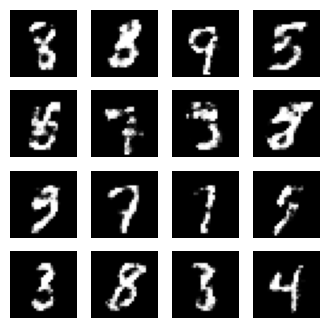

Epoch 801, Discriminator Loss: 0.27857470512390137, Generator Loss: 2.4106333255767822
Epoch 802, Discriminator Loss: 0.3410326838493347, Generator Loss: 2.701691150665283
Epoch 803, Discriminator Loss: 0.28551316261291504, Generator Loss: 2.3321449756622314
Epoch 804, Discriminator Loss: 0.2556534707546234, Generator Loss: 1.9754678010940552
Epoch 805, Discriminator Loss: 0.2297782152891159, Generator Loss: 2.2327890396118164
Epoch 806, Discriminator Loss: 0.281326025724411, Generator Loss: 2.4505624771118164
Epoch 807, Discriminator Loss: 0.41519027948379517, Generator Loss: 1.7900512218475342
Epoch 808, Discriminator Loss: 0.2568179965019226, Generator Loss: 2.639058828353882
Epoch 809, Discriminator Loss: 0.28510868549346924, Generator Loss: 2.5169081687927246
Epoch 810, Discriminator Loss: 0.4267912209033966, Generator Loss: 2.445979595184326


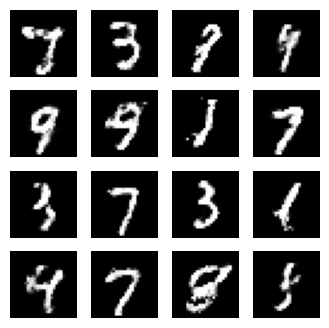

Epoch 811, Discriminator Loss: 0.19830510020256042, Generator Loss: 2.214992046356201
Epoch 812, Discriminator Loss: 0.3051948547363281, Generator Loss: 2.1536567211151123
Epoch 813, Discriminator Loss: 0.2902698218822479, Generator Loss: 2.0767416954040527
Epoch 814, Discriminator Loss: 0.4393429756164551, Generator Loss: 2.5831246376037598
Epoch 815, Discriminator Loss: 0.32027870416641235, Generator Loss: 2.078601837158203
Epoch 816, Discriminator Loss: 0.3162982761859894, Generator Loss: 2.4800260066986084
Epoch 817, Discriminator Loss: 0.28221845626831055, Generator Loss: 2.6806905269622803
Epoch 818, Discriminator Loss: 0.30840450525283813, Generator Loss: 2.0075433254241943
Epoch 819, Discriminator Loss: 0.3208875358104706, Generator Loss: 2.2498388290405273
Epoch 820, Discriminator Loss: 0.3678956627845764, Generator Loss: 2.4930474758148193


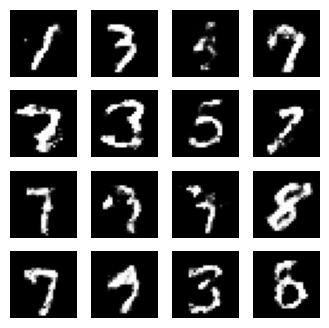

Epoch 821, Discriminator Loss: 0.20698611438274384, Generator Loss: 3.096057415008545
Epoch 822, Discriminator Loss: 0.24253350496292114, Generator Loss: 2.3389909267425537
Epoch 823, Discriminator Loss: 0.3257124722003937, Generator Loss: 2.708995819091797
Epoch 824, Discriminator Loss: 0.14194044470787048, Generator Loss: 2.907961845397949
Epoch 825, Discriminator Loss: 0.2526335120201111, Generator Loss: 2.3267085552215576
Epoch 826, Discriminator Loss: 0.2866325378417969, Generator Loss: 2.4253525733947754
Epoch 827, Discriminator Loss: 0.28146564960479736, Generator Loss: 2.2045838832855225
Epoch 828, Discriminator Loss: 0.45015740394592285, Generator Loss: 2.2594263553619385
Epoch 829, Discriminator Loss: 0.22980406880378723, Generator Loss: 2.731700897216797
Epoch 830, Discriminator Loss: 0.31384387612342834, Generator Loss: 2.319683790206909


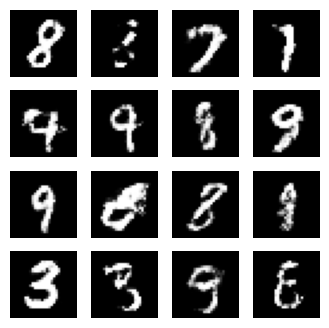

Epoch 831, Discriminator Loss: 0.30739647150039673, Generator Loss: 2.713150978088379
Epoch 832, Discriminator Loss: 0.16625994443893433, Generator Loss: 2.8208069801330566
Epoch 833, Discriminator Loss: 0.32091885805130005, Generator Loss: 2.157241106033325
Epoch 834, Discriminator Loss: 0.19608935713768005, Generator Loss: 2.1543426513671875
Epoch 835, Discriminator Loss: 0.344735324382782, Generator Loss: 2.289567470550537
Epoch 836, Discriminator Loss: 0.28106409311294556, Generator Loss: 2.2746517658233643
Epoch 837, Discriminator Loss: 0.3230108916759491, Generator Loss: 2.5812716484069824
Epoch 838, Discriminator Loss: 0.3897414207458496, Generator Loss: 2.5215601921081543
Epoch 839, Discriminator Loss: 0.18127025663852692, Generator Loss: 2.6368441581726074
Epoch 840, Discriminator Loss: 0.2361249327659607, Generator Loss: 2.7004151344299316


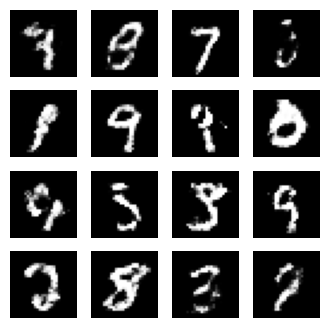

Epoch 841, Discriminator Loss: 0.22233760356903076, Generator Loss: 3.0339858531951904
Epoch 842, Discriminator Loss: 0.40731582045555115, Generator Loss: 2.3864147663116455
Epoch 843, Discriminator Loss: 0.32644644379615784, Generator Loss: 2.2659242153167725
Epoch 844, Discriminator Loss: 0.2762514650821686, Generator Loss: 2.8062615394592285
Epoch 845, Discriminator Loss: 0.32336875796318054, Generator Loss: 2.188800811767578
Epoch 846, Discriminator Loss: 0.3092420995235443, Generator Loss: 2.4389450550079346
Epoch 847, Discriminator Loss: 0.28345394134521484, Generator Loss: 2.46506404876709
Epoch 848, Discriminator Loss: 0.34989285469055176, Generator Loss: 2.3588733673095703
Epoch 849, Discriminator Loss: 0.4253096282482147, Generator Loss: 2.5344247817993164
Epoch 850, Discriminator Loss: 0.3295517563819885, Generator Loss: 2.8726983070373535


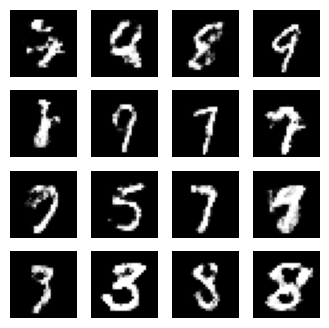

Epoch 851, Discriminator Loss: 0.39817649126052856, Generator Loss: 2.5634889602661133
Epoch 852, Discriminator Loss: 0.3344604969024658, Generator Loss: 2.862348794937134
Epoch 853, Discriminator Loss: 0.27823710441589355, Generator Loss: 3.070289134979248
Epoch 854, Discriminator Loss: 0.2893804907798767, Generator Loss: 3.00991153717041
Epoch 855, Discriminator Loss: 0.2703920602798462, Generator Loss: 2.583026885986328
Epoch 856, Discriminator Loss: 0.34933462738990784, Generator Loss: 2.350959300994873
Epoch 857, Discriminator Loss: 0.23413993418216705, Generator Loss: 3.917731761932373
Epoch 858, Discriminator Loss: 0.27478206157684326, Generator Loss: 2.3229026794433594
Epoch 859, Discriminator Loss: 0.2281966358423233, Generator Loss: 2.403810977935791
Epoch 860, Discriminator Loss: 0.19907253980636597, Generator Loss: 2.278801679611206


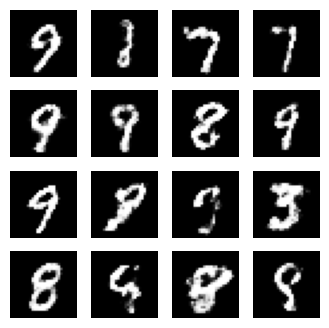

Epoch 861, Discriminator Loss: 0.3089391589164734, Generator Loss: 2.736684799194336
Epoch 862, Discriminator Loss: 0.24888163805007935, Generator Loss: 2.51309871673584
Epoch 863, Discriminator Loss: 0.31359946727752686, Generator Loss: 2.456601619720459
Epoch 864, Discriminator Loss: 0.1938311904668808, Generator Loss: 2.9298195838928223
Epoch 865, Discriminator Loss: 0.24398528039455414, Generator Loss: 2.623227596282959
Epoch 866, Discriminator Loss: 0.27191105484962463, Generator Loss: 2.6066293716430664
Epoch 867, Discriminator Loss: 0.25501346588134766, Generator Loss: 2.070521593093872
Epoch 868, Discriminator Loss: 0.2732902467250824, Generator Loss: 2.2836508750915527
Epoch 869, Discriminator Loss: 0.29637080430984497, Generator Loss: 1.7968647480010986
Epoch 870, Discriminator Loss: 0.36419230699539185, Generator Loss: 2.374663829803467


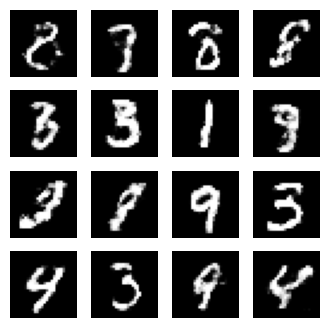

Epoch 871, Discriminator Loss: 0.3006490468978882, Generator Loss: 1.7682808637619019
Epoch 872, Discriminator Loss: 0.2649739980697632, Generator Loss: 2.7802321910858154
Epoch 873, Discriminator Loss: 0.4245949685573578, Generator Loss: 2.1895580291748047
Epoch 874, Discriminator Loss: 0.22552348673343658, Generator Loss: 2.6472554206848145
Epoch 875, Discriminator Loss: 0.2804182767868042, Generator Loss: 1.9624868631362915
Epoch 876, Discriminator Loss: 0.2346116006374359, Generator Loss: 2.4950828552246094
Epoch 877, Discriminator Loss: 0.3230447471141815, Generator Loss: 2.6243443489074707
Epoch 878, Discriminator Loss: 0.2929089665412903, Generator Loss: 2.9665017127990723
Epoch 879, Discriminator Loss: 0.32978516817092896, Generator Loss: 2.1079351902008057
Epoch 880, Discriminator Loss: 0.25520044565200806, Generator Loss: 2.754591703414917


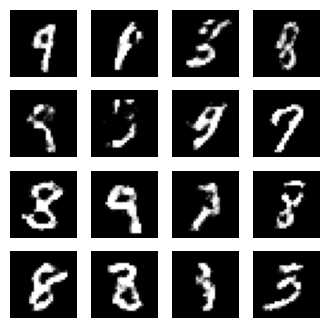

Epoch 881, Discriminator Loss: 0.2308269739151001, Generator Loss: 2.4569170475006104
Epoch 882, Discriminator Loss: 0.2505580186843872, Generator Loss: 2.4791431427001953
Epoch 883, Discriminator Loss: 0.34976619482040405, Generator Loss: 2.4342026710510254
Epoch 884, Discriminator Loss: 0.33978813886642456, Generator Loss: 2.3762261867523193
Epoch 885, Discriminator Loss: 0.34415462613105774, Generator Loss: 2.3122618198394775
Epoch 886, Discriminator Loss: 0.11939316987991333, Generator Loss: 3.0307955741882324
Epoch 887, Discriminator Loss: 0.34392598271369934, Generator Loss: 2.6544196605682373
Epoch 888, Discriminator Loss: 0.18277491629123688, Generator Loss: 3.015517234802246
Epoch 889, Discriminator Loss: 0.39650318026542664, Generator Loss: 2.6544737815856934
Epoch 890, Discriminator Loss: 0.22696855664253235, Generator Loss: 2.618941307067871


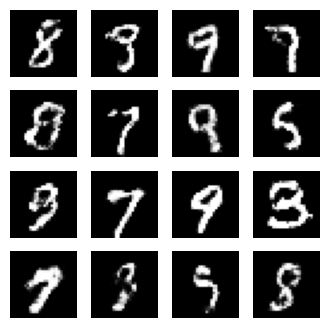

Epoch 891, Discriminator Loss: 0.3005061149597168, Generator Loss: 2.724348545074463
Epoch 892, Discriminator Loss: 0.15682747960090637, Generator Loss: 2.582172393798828
Epoch 893, Discriminator Loss: 0.2037430703639984, Generator Loss: 2.43459153175354
Epoch 894, Discriminator Loss: 0.27712053060531616, Generator Loss: 2.352721929550171
Epoch 895, Discriminator Loss: 0.3547644317150116, Generator Loss: 2.3513200283050537
Epoch 896, Discriminator Loss: 0.2832241654396057, Generator Loss: 2.2082042694091797
Epoch 897, Discriminator Loss: 0.1975850909948349, Generator Loss: 2.987731456756592
Epoch 898, Discriminator Loss: 0.22875867784023285, Generator Loss: 2.5758144855499268
Epoch 899, Discriminator Loss: 0.20098696649074554, Generator Loss: 2.9357070922851562
Epoch 900, Discriminator Loss: 0.27788257598876953, Generator Loss: 2.526193141937256


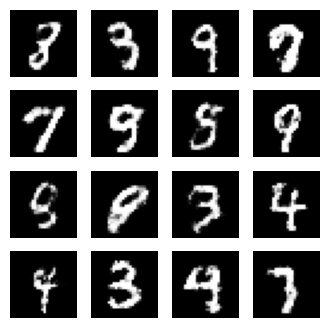

Epoch 901, Discriminator Loss: 0.359731525182724, Generator Loss: 2.239192485809326
Epoch 902, Discriminator Loss: 0.17114266753196716, Generator Loss: 3.2400474548339844
Epoch 903, Discriminator Loss: 0.2769435942173004, Generator Loss: 2.31351900100708
Epoch 904, Discriminator Loss: 0.28913724422454834, Generator Loss: 2.7737374305725098
Epoch 905, Discriminator Loss: 0.2570125460624695, Generator Loss: 2.434692144393921
Epoch 906, Discriminator Loss: 0.2895636558532715, Generator Loss: 2.4414217472076416
Epoch 907, Discriminator Loss: 0.3307989239692688, Generator Loss: 1.9148294925689697
Epoch 908, Discriminator Loss: 0.32321780920028687, Generator Loss: 2.0136513710021973
Epoch 909, Discriminator Loss: 0.24498581886291504, Generator Loss: 2.648207187652588
Epoch 910, Discriminator Loss: 0.24311241507530212, Generator Loss: 2.587423324584961


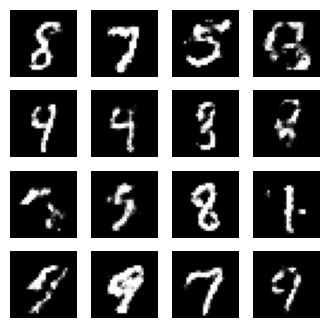

Epoch 911, Discriminator Loss: 0.2622397840023041, Generator Loss: 2.3807225227355957
Epoch 912, Discriminator Loss: 0.2679094672203064, Generator Loss: 2.3436167240142822
Epoch 913, Discriminator Loss: 0.2970348000526428, Generator Loss: 2.669034719467163
Epoch 914, Discriminator Loss: 0.2194618433713913, Generator Loss: 3.0102176666259766
Epoch 915, Discriminator Loss: 0.2674105167388916, Generator Loss: 2.260963201522827
Epoch 916, Discriminator Loss: 0.21636714041233063, Generator Loss: 2.221229076385498
Epoch 917, Discriminator Loss: 0.2968693673610687, Generator Loss: 2.638335704803467
Epoch 918, Discriminator Loss: 0.28802669048309326, Generator Loss: 2.5049877166748047
Epoch 919, Discriminator Loss: 0.30800294876098633, Generator Loss: 2.1846160888671875
Epoch 920, Discriminator Loss: 0.22899961471557617, Generator Loss: 2.511676788330078


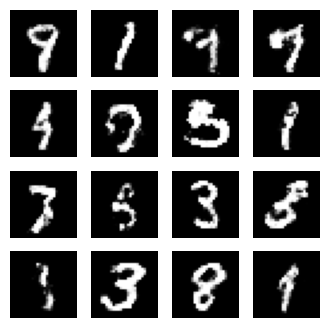

Epoch 921, Discriminator Loss: 0.24431368708610535, Generator Loss: 2.1707234382629395
Epoch 922, Discriminator Loss: 0.19376856088638306, Generator Loss: 2.449383497238159
Epoch 923, Discriminator Loss: 0.2062862515449524, Generator Loss: 2.4227139949798584
Epoch 924, Discriminator Loss: 0.20491191744804382, Generator Loss: 2.7331318855285645
Epoch 925, Discriminator Loss: 0.28214967250823975, Generator Loss: 2.6236512660980225
Epoch 926, Discriminator Loss: 0.35440361499786377, Generator Loss: 2.2339396476745605
Epoch 927, Discriminator Loss: 0.41931504011154175, Generator Loss: 2.3310012817382812
Epoch 928, Discriminator Loss: 0.3419398069381714, Generator Loss: 2.240220785140991
Epoch 929, Discriminator Loss: 0.2686936855316162, Generator Loss: 2.386526107788086
Epoch 930, Discriminator Loss: 0.3952268064022064, Generator Loss: 1.8469020128250122


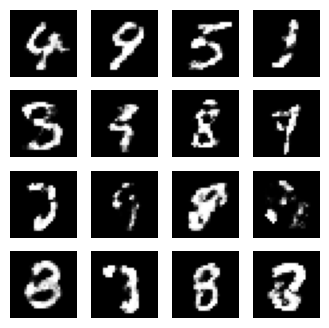

Epoch 931, Discriminator Loss: 0.3525609076023102, Generator Loss: 2.2660579681396484
Epoch 932, Discriminator Loss: 0.2306472659111023, Generator Loss: 2.7610044479370117
Epoch 933, Discriminator Loss: 0.3855133652687073, Generator Loss: 2.0794382095336914
Epoch 934, Discriminator Loss: 0.33474063873291016, Generator Loss: 2.785651922225952
Epoch 935, Discriminator Loss: 0.3189392387866974, Generator Loss: 2.1464507579803467
Epoch 936, Discriminator Loss: 0.45471128821372986, Generator Loss: 2.2128639221191406
Epoch 937, Discriminator Loss: 0.27902549505233765, Generator Loss: 2.01237154006958
Epoch 938, Discriminator Loss: 0.26592087745666504, Generator Loss: 2.6549525260925293
Epoch 939, Discriminator Loss: 0.23149830102920532, Generator Loss: 2.4571964740753174
Epoch 940, Discriminator Loss: 0.23852288722991943, Generator Loss: 2.2471795082092285


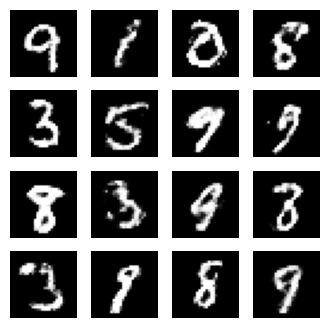

Epoch 941, Discriminator Loss: 0.3776206970214844, Generator Loss: 2.5506036281585693
Epoch 942, Discriminator Loss: 0.2619353234767914, Generator Loss: 2.3018760681152344
Epoch 943, Discriminator Loss: 0.23157280683517456, Generator Loss: 2.410222053527832
Epoch 944, Discriminator Loss: 0.32447177171707153, Generator Loss: 2.30722713470459
Epoch 945, Discriminator Loss: 0.33898448944091797, Generator Loss: 2.477940559387207
Epoch 946, Discriminator Loss: 0.2820753753185272, Generator Loss: 1.935941457748413
Epoch 947, Discriminator Loss: 0.27025702595710754, Generator Loss: 2.7169578075408936
Epoch 948, Discriminator Loss: 0.3335726857185364, Generator Loss: 2.3255057334899902
Epoch 949, Discriminator Loss: 0.27693670988082886, Generator Loss: 2.074489116668701
Epoch 950, Discriminator Loss: 0.361629843711853, Generator Loss: 2.2954041957855225


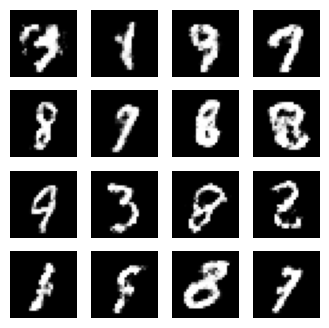

Epoch 951, Discriminator Loss: 0.3010386824607849, Generator Loss: 3.082268714904785
Epoch 952, Discriminator Loss: 0.27842244505882263, Generator Loss: 2.769695520401001
Epoch 953, Discriminator Loss: 0.2726730406284332, Generator Loss: 2.4619383811950684
Epoch 954, Discriminator Loss: 0.2858849763870239, Generator Loss: 2.9376490116119385
Epoch 955, Discriminator Loss: 0.2552545666694641, Generator Loss: 2.2567930221557617
Epoch 956, Discriminator Loss: 0.2739392817020416, Generator Loss: 2.790104389190674
Epoch 957, Discriminator Loss: 0.3441182076931, Generator Loss: 3.0331101417541504
Epoch 958, Discriminator Loss: 0.24992002546787262, Generator Loss: 2.3936996459960938
Epoch 959, Discriminator Loss: 0.2574508488178253, Generator Loss: 2.516026496887207
Epoch 960, Discriminator Loss: 0.29511773586273193, Generator Loss: 2.474139451980591


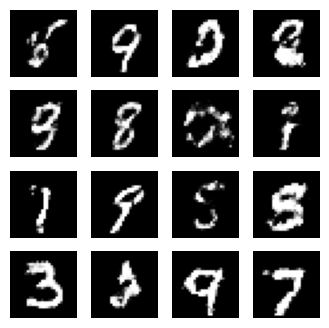

Epoch 961, Discriminator Loss: 0.3089967370033264, Generator Loss: 2.164492607116699
Epoch 962, Discriminator Loss: 0.32795268297195435, Generator Loss: 2.4903762340545654
Epoch 963, Discriminator Loss: 0.24526862800121307, Generator Loss: 2.291658401489258
Epoch 964, Discriminator Loss: 0.2616717517375946, Generator Loss: 2.5267622470855713
Epoch 965, Discriminator Loss: 0.23493292927742004, Generator Loss: 2.136134624481201
Epoch 966, Discriminator Loss: 0.2633015811443329, Generator Loss: 2.3883349895477295
Epoch 967, Discriminator Loss: 0.31708118319511414, Generator Loss: 2.455355644226074
Epoch 968, Discriminator Loss: 0.29100343585014343, Generator Loss: 2.16330623626709
Epoch 969, Discriminator Loss: 0.32737356424331665, Generator Loss: 2.297048568725586
Epoch 970, Discriminator Loss: 0.33316344022750854, Generator Loss: 2.468701124191284


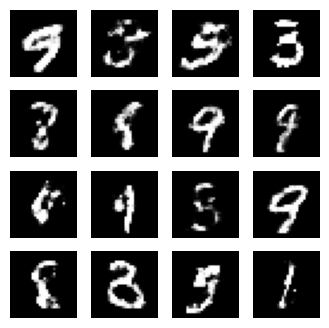

Epoch 971, Discriminator Loss: 0.24712568521499634, Generator Loss: 2.037201404571533
Epoch 972, Discriminator Loss: 0.2557130753993988, Generator Loss: 1.9822709560394287
Epoch 973, Discriminator Loss: 0.17955279350280762, Generator Loss: 2.664522171020508
Epoch 974, Discriminator Loss: 0.33979475498199463, Generator Loss: 2.2940664291381836
Epoch 975, Discriminator Loss: 0.24020518362522125, Generator Loss: 2.4514739513397217
Epoch 976, Discriminator Loss: 0.36589598655700684, Generator Loss: 2.252560615539551
Epoch 977, Discriminator Loss: 0.33827638626098633, Generator Loss: 2.069922924041748
Epoch 978, Discriminator Loss: 0.24460971355438232, Generator Loss: 2.4702086448669434
Epoch 979, Discriminator Loss: 0.23832765221595764, Generator Loss: 2.34372615814209
Epoch 980, Discriminator Loss: 0.32253405451774597, Generator Loss: 1.9754467010498047


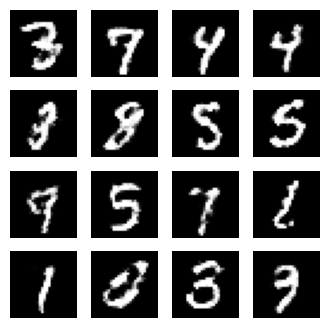

Epoch 981, Discriminator Loss: 0.26756322383880615, Generator Loss: 2.4433164596557617
Epoch 982, Discriminator Loss: 0.347868412733078, Generator Loss: 2.10689377784729
Epoch 983, Discriminator Loss: 0.2865714728832245, Generator Loss: 2.1755542755126953
Epoch 984, Discriminator Loss: 0.2373320758342743, Generator Loss: 2.6789908409118652
Epoch 985, Discriminator Loss: 0.4211820960044861, Generator Loss: 2.2336885929107666
Epoch 986, Discriminator Loss: 0.27471399307250977, Generator Loss: 2.2734556198120117
Epoch 987, Discriminator Loss: 0.2877216935157776, Generator Loss: 2.847808837890625
Epoch 988, Discriminator Loss: 0.2396664023399353, Generator Loss: 1.870854377746582
Epoch 989, Discriminator Loss: 0.25743094086647034, Generator Loss: 1.9727487564086914
Epoch 990, Discriminator Loss: 0.33422577381134033, Generator Loss: 2.0577845573425293


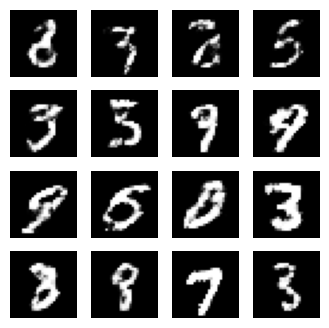

Epoch 991, Discriminator Loss: 0.28249451518058777, Generator Loss: 2.416895627975464
Epoch 992, Discriminator Loss: 0.25469785928726196, Generator Loss: 2.499650239944458
Epoch 993, Discriminator Loss: 0.24566900730133057, Generator Loss: 2.638422727584839
Epoch 994, Discriminator Loss: 0.2649082839488983, Generator Loss: 2.2442545890808105
Epoch 995, Discriminator Loss: 0.3148925304412842, Generator Loss: 2.5563011169433594
Epoch 996, Discriminator Loss: 0.3788324296474457, Generator Loss: 2.2410638332366943
Epoch 997, Discriminator Loss: 0.2724548876285553, Generator Loss: 2.2057154178619385
Epoch 998, Discriminator Loss: 0.31033003330230713, Generator Loss: 2.028456211090088
Epoch 999, Discriminator Loss: 0.23639965057373047, Generator Loss: 2.2609829902648926
Epoch 1000, Discriminator Loss: 0.3375934362411499, Generator Loss: 2.161736011505127


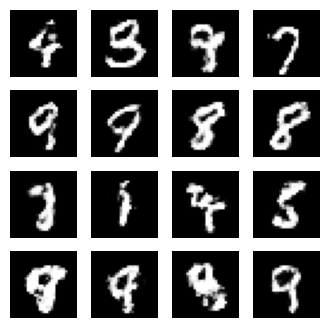

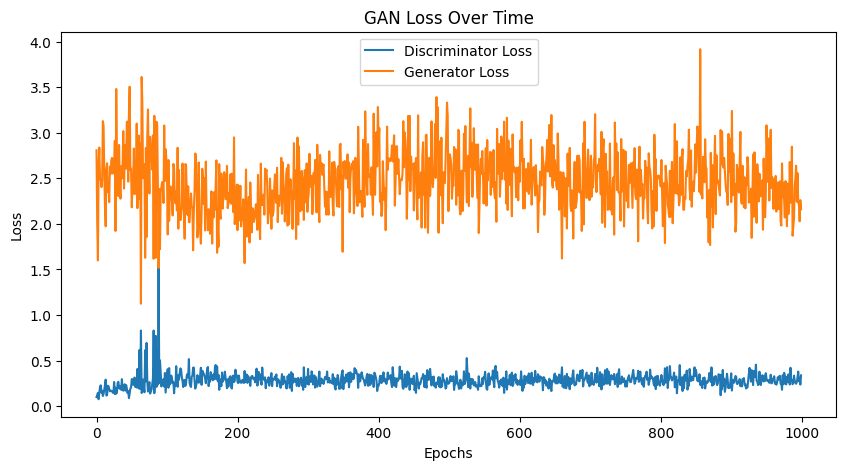

In [18]:
# Train the GAN
train_gan(generator, discriminator, dataset, epochs=1000, batch_size=64) # Minimum Epochs : 10000

In [19]:
# Save the trained models
save_model(generator, discriminator)

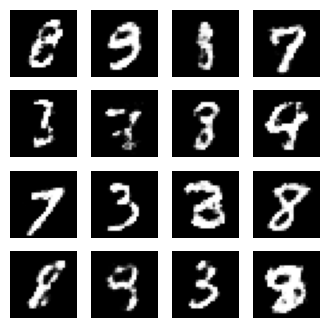

In [28]:
# Generate images from the saved generator model after training
generate_images_from_saved_model()